In [241]:
from Levenshtein import distance as levenshtein
from zipfile import ZipFile
from tqdm.auto import tqdm, trange
import ncbi.datasets
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
# Plotting configuration
sns.set()
plt.rcParams.update({
    'text.usetex': False,
    'figure.constrained_layout.use': True,
    'figure.dpi': 300,
    'figure.figsize': ((W := 8.27 - 2*0.04167 - 2*(PAD := 0.2)), W/(3/2)),
    'savefig.pad_inches': 2*0.041672 + PAD,
    'savefig.bbox': 'tight',
    'font.size' : 11,
    'axes.labelsize': 11,
    'legend.fontsize': 11,
})
if plt.rcParams['text.usetex']:
    plt.rcParams.update({
        'text.latex.preamble': (
            r'\usepackage{lmodern}'
            r'\usepackage[T1]{fontenc}'
            r'\usepackage[utf8]{inputenc}'
            r'\usepackage{siunitx}'
            r'\usepackage{physics}'
            r'\usepackage{sansmath}'           # Disable for roman font
            r'\sansmath'                       # *
        ),
        # 'font.family': 'lmodern',              # Disable for sans-serif
    })
%config InlineBackend.figure_formats = 'png' #'svg', 'pdf', 'retina'


In [2]:
api_instance = ncbi.datasets.GenomeApi(ncbi.datasets.ApiClient())

In [60]:
with open('assembly/ncbi_dataset/data/GCF_000001405.39/chrMT.fna') as f:
    human = f.read()
human = ''.join(human.split('\n')[1:])

In [61]:
with open('assembly/ncbi_dataset/data/GCF_002880755.1/chrMT.fna') as f:
    chimp = f.read()
chimp = ''.join(chimp.split('\n')[1:])

In [63]:
with open('assembly/ncbi_dataset/data/GCF_000001515.7/chrMT.fna') as f:
    chimp2 = f.read()
chimp2 = ''.join(chimp2.split('\n')[1:])

In [62]:
with open('assembly/ncbi_dataset/data/GCF_009663435.1/chrMT.fna') as f:
    marmoset = f.read()
marmoset = ''.join(marmoset.split('\n')[1:])

In [48]:
len(human)

16569

In [49]:
len(chimp)

16554

In [64]:
len(chimp2)

16554

In [50]:
len(marmoset)

16499

In [53]:
distance(human, chimp)

2502

In [54]:
distance(human, marmoset)

4735

In [55]:
distance(chimp, marmoset)

4062

In [65]:
distance(chimp, chimp2)

0

In [4]:
# Search the NCBI database for all listed eukaryotes
genome_summary = api_instance.assembly_descriptors_by_taxon(taxon='eukaryotes', page_size=1000)
eukaryotes = genome_summary.assemblies
page_token = genome_summary.next_page_token
pbar = tqdm(total=genome_summary.total_count)
pbar.update(len(eukaryotes))
while page_token:
    genome_summary = api_instance.assembly_descriptors_by_taxon(
        taxon='eukaryotes', page_size=1000, page_token=page_token)
    a = genome_summary.assemblies
    page_token = genome_summary.next_page_token
    pbar.update(len(a))
    eukaryotes += a
pbar.close()

  0%|          | 0/21505 [00:00<?, ?it/s]

In [5]:
# Filter out all without mitochondrium sequence data and build DataFrame
species = pd.DataFrame([{'id': x['assembly']['assembly_accession'], 'name': x['assembly']['org']['title']}
                        for x in eukaryotes for y in x['assembly']['chromosomes'] if y['name'] == 'MT'])

In [6]:
species

id                      name
0     GCA_002812265.1        Abeoforma whisleri
1     GCA_905340225.1      Abrostola tripartita
2     GCF_001949145.1  crown-of-thorns starfish
3     GCA_016904835.1                  rifleman
4     GCA_021347895.1             spiny chromis
...               ...                       ...
3587  GCA_002926055.1       [Candida] haemuloni
3588  GCA_017309295.1     [Candida] nivariensis
3589  GCA_003243815.1            [Candida] sake
3590  GCA_019202705.1       [Candida] subhashii
3591  GCA_002939055.1          fungal sp. Mo6-1

[3592 rows x 2 columns]

In [7]:
for i in trange(0, len(species), 100):
    # Download assemly descriptions, including download URL
    api_response = api_instance.download_assembly_package(
        species.iloc[i : i + 100].id.to_list(), chromosomes=['MT'], hydrated="DATA_REPORT_ONLY")

    # Write zip file with assembly descriptions
    with open('data/assemblies.zip', 'wb') as f:
        f.write(api_response.read())

    # Extract zip file
    with ZipFile('data/assemblies.zip', 'r') as f:
        f.extractall('data/assemblies')
    
    # Download mitochondrium dna sequences
    with open("data/assemblies/ncbi_dataset/fetch.txt") as f:
        for line in f:
            ls = line.split()
            
            # For those assemblies that actually contain a file with the mitochondrium sequence,
            # download and store DNA
            if ls[-1].endswith('chrMT.fna'):
                r = requests.get(ls[0])
                dna = ''.join(r.text.split('\n')[1:])
                index = species[species.id == ls[-1].split('/')[1]].index[0]
                species.loc[index, 'dna'] = dna

  0%|          | 0/36 [00:00<?, ?it/s]

In [30]:
# Filter out species with no DNA information and remove duplicates
species = species[~species.dna.isna()]
species = species[species.dna.str.len() > 0]
species = species.drop_duplicates('name')
species = species.reset_index(drop=True)
species

id                          name  \
0    GCA_905340225.1          Abrostola tripartita   
1    GCF_001949145.1      crown-of-thorns starfish   
2    GCA_016904835.1                      rifleman   
3    GCA_021347895.1                 spiny chromis   
4    GCF_904848185.1            yellowfin seabream   
..               ...                           ...   
719  GCA_020796205.1  Ziziphus jujuba var. spinosa   
720  GCF_000696155.1       Zootermopsis nevadensis   
721  GCF_011800845.1                 common lizard   
722  GCA_907165275.2          Zygaena filipendulae   
723  GCA_002219185.1            [Candida] glabrata   

                                                   dna  
0    AAAATCTTCCACCTGCTGAACATTCATATAATGAACTTCCAATTTT...  
1    AGATAGAAACTGACCTGGCTCACGCCGGTCTGAACTCAGATCACGT...  
2    GTCCCTGTAGCTTAATAAAAAGCATAACACTGAAGATGTTAAGACG...  
3    GCGTAGCTTAACTAGAGCATAACTCTGAAGATGTTAGGGTGGACCT...  
4    GCTCACGTAGCTTAATTAAAGCATAACATTGAAGCCGTTAAGATGG...  
..                                                 ...  
719  AGGGGCATCTTTCTTTCTCCCATTCTTTCTGTTGGTCAACAACCAA...  
720  AATGGAGTGCCTGAAAAAGGATTACTATGATAGGGTAAATAATGTA...  
721  GTCATTGTAGCTTATTTTTTTGAAAGCACGGCACTGAAAATGCCGA...  
722  ATTTAAAGCATTATTATTTATATGTGCTGGTGTTATTATCCATATA...  
723  TAAATATTTTAAACTTGTATAGTTTAAATGGTTAAAACATTTGTCT...  

[724 rows x 3 columns]

In [31]:
len(speciesdd)

724

In [34]:
def single_linkage(A, B, d):
    min_ = np.inf
    for a in A:
        for b in B:
            min_ = min(min_, d(a, b))

In [40]:
K = np.empty((len(species), len(species)))
for i in trange(len(species)):
    for j in trange(i, len(species), leave=False):
        K[i, j] = K[j, i] = distance(species.dna[i], species.dna[j])

  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/724 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
K = np.empty((10, 10))
for i in trange(10):
    for j in trange(i, 10, leave=False):
        K[i, j] = K[j, i] = distance(species.dna[i], species.dna[j])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

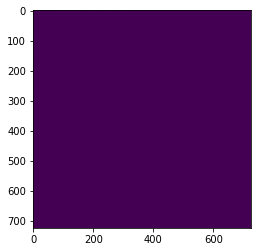

In [44]:
plt.imshow(K)

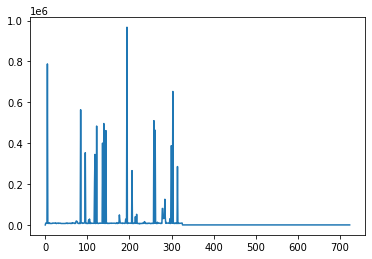

In [45]:
plt.plot(K[0])

In [113]:
seen = []
mt_assemblies = {}
for k, v in mt_assemblies_.items():
    if v['name'] not in seen and 'dna' in v:
        mt_assemblies[k] = v
        seen.append(v['name'])

In [117]:
len(mt_assemblies)

725

In [139]:
lens = []
for k in mt_assemblies:
    if (l := len(mt_assemblies[k]['dna'])) > 0:
        lens.append(np.log10(l))

In [121]:
import matplotlib.pyplot as plt

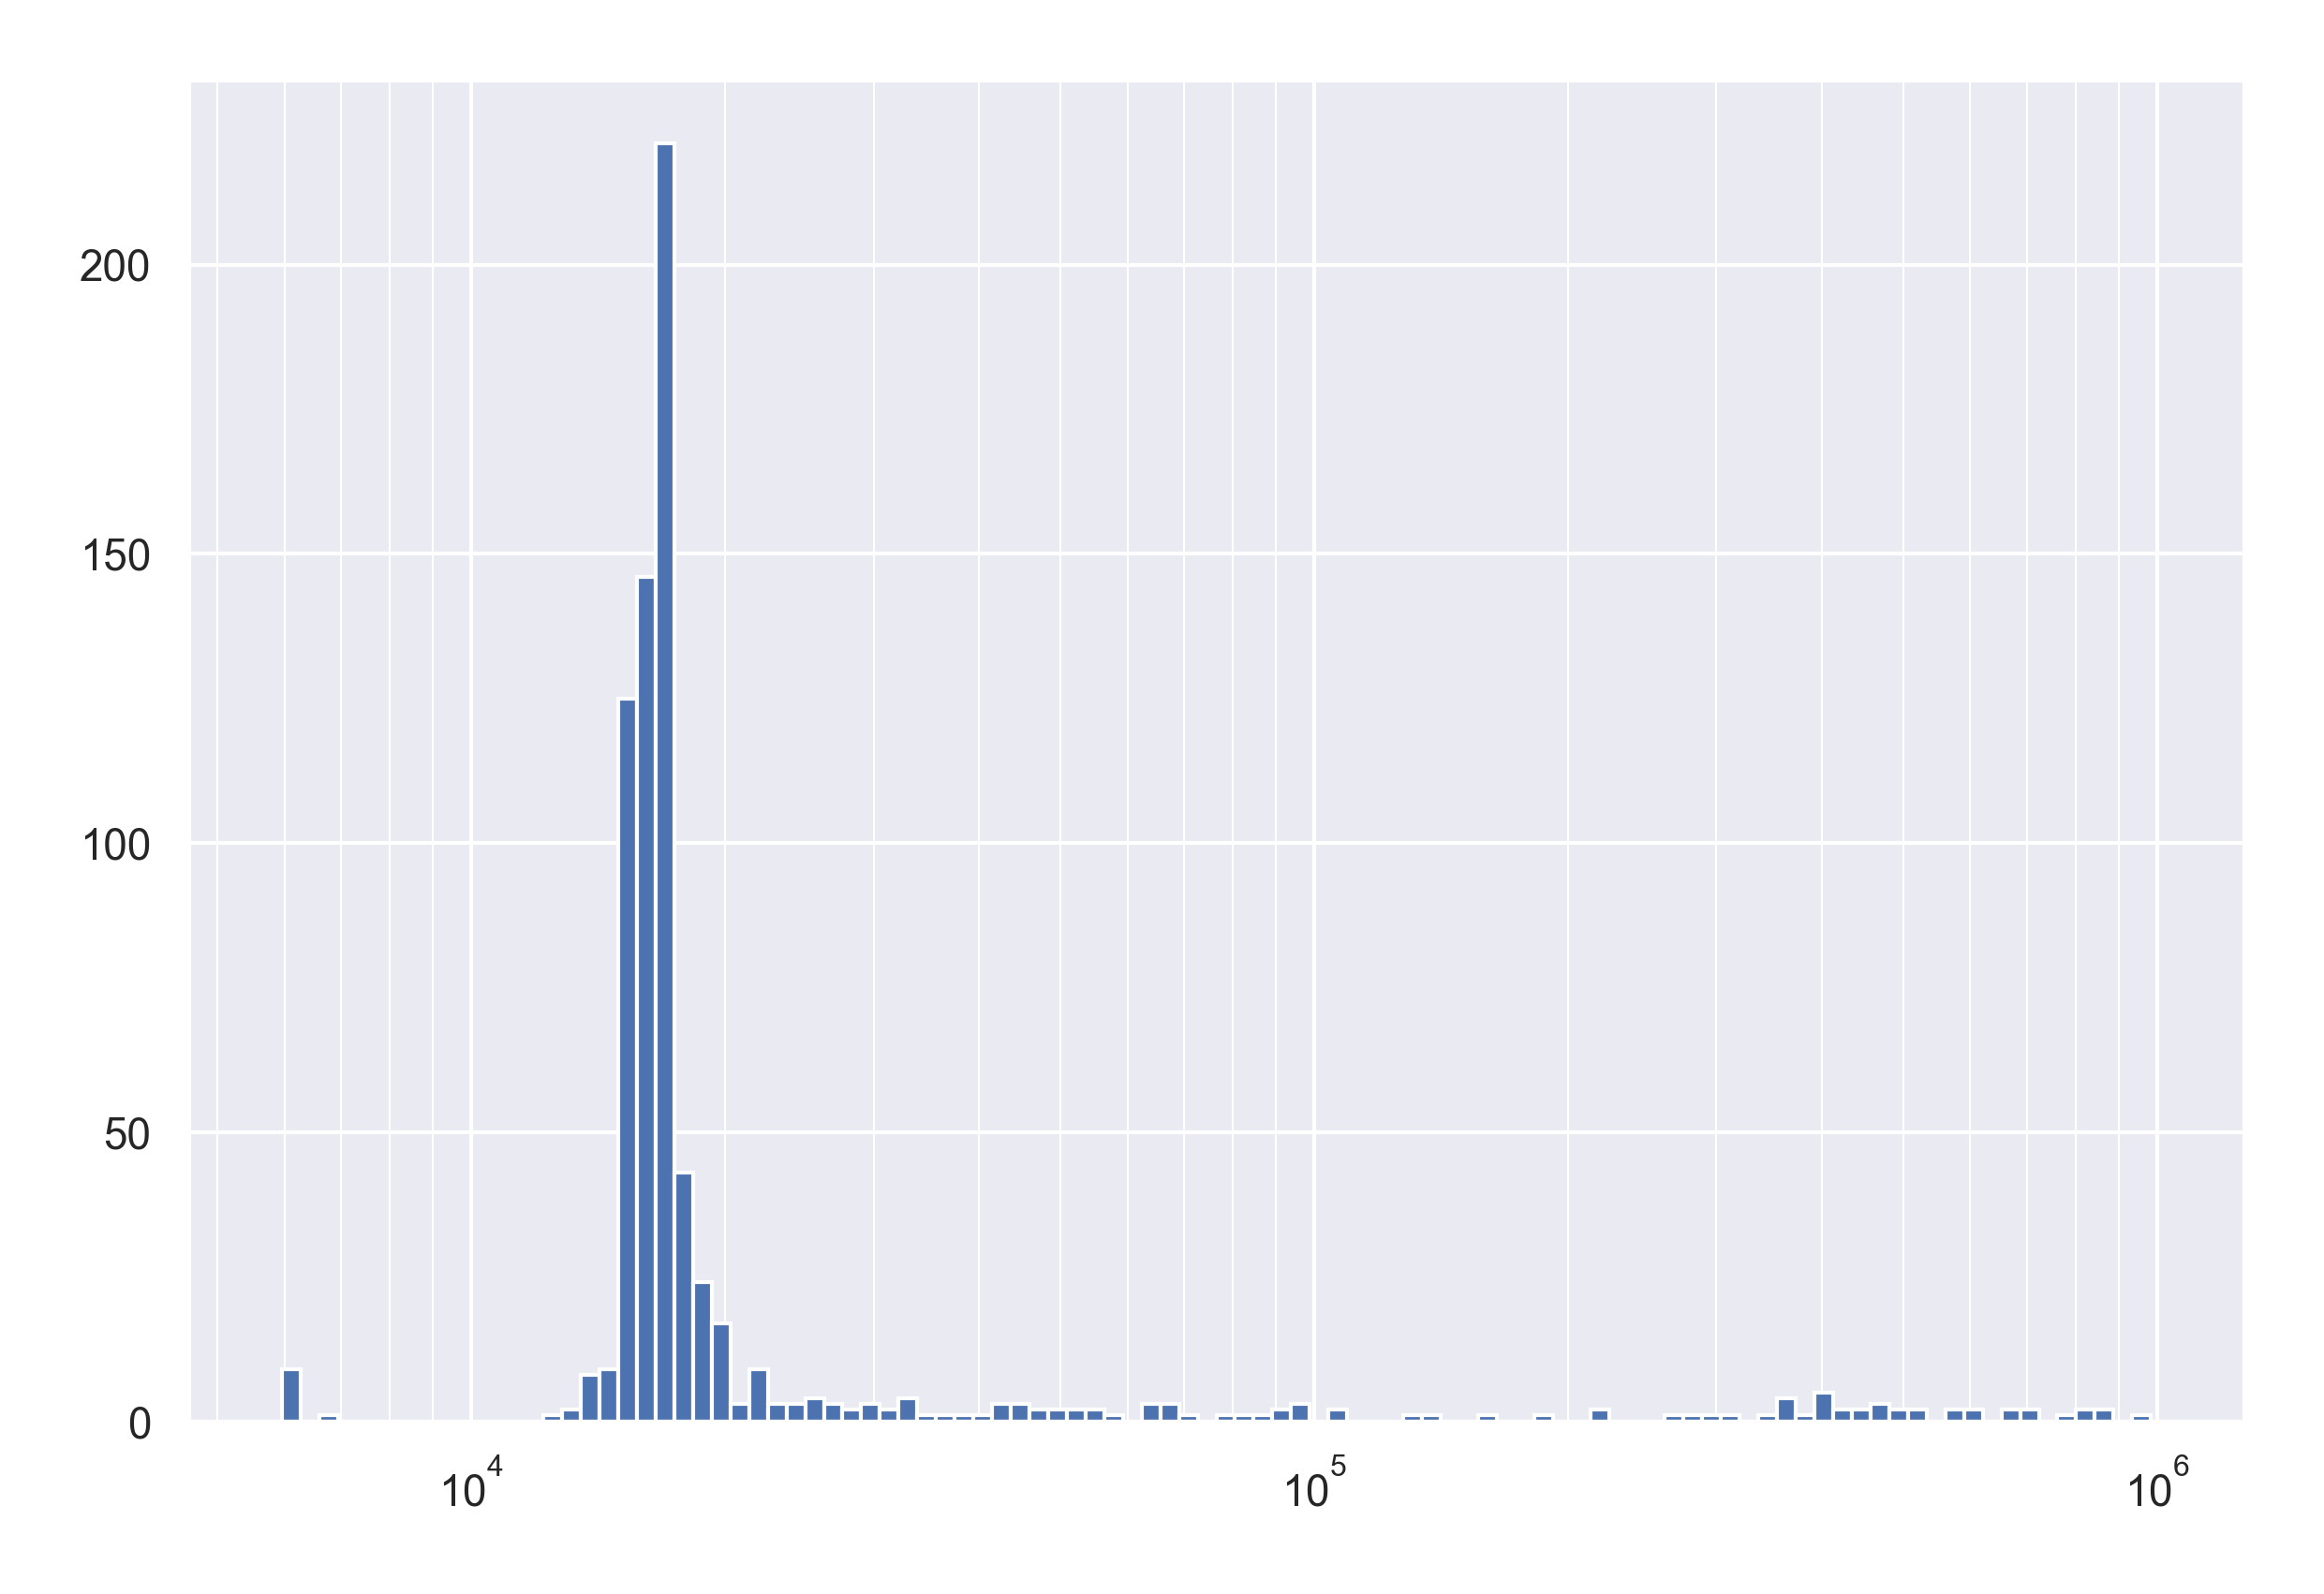

In [240]:
lens = species.dna.str.len()
hist, bins, _ = plt.hist(lens, 100)
plt.close()

fig, ax = plt.subplots()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax.hist(lens, bins=logbins)
ax.set_xscale('log')
ax.xaxis.grid(which='minor', lw=0.5)
plt.show()

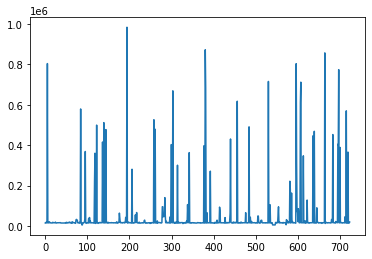

In [51]:
plt.plot(species.dna.str.len())

In [59]:
species_ = species[species.dna.str.len() < 30_000].reset_index(drop=True)

In [60]:
K = np.empty((len(species_), len(species_)))
for i in trange(len(species_)):
    for j in trange(i, len(species_), leave=False):
        K[i, j] = K[j, i] = distance(species_.dna[i], species_.dna[j])

  0%|          | 0/636 [00:00<?, ?it/s]

  0%|          | 0/636 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [54]:
len(species.dna.str.len()[species.dna.str.len() > 30_000])

88

In [74]:
#K = np.empty((10, 10))
yd = []
for i in trange(10):
    for j in trange(i + 1, 10, leave=False):
        yd.append(distance(species_.dna[i], species_.dna[j]))
#        K[i, j] = K[j, i] = distance(species_.dna[i], species_.dna[j])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

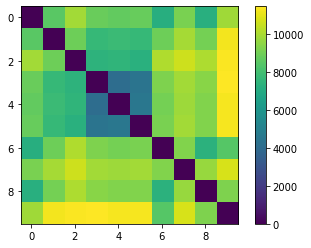

In [63]:
plt.imshow(K)
plt.colorbar()

In [ ]:
single_linkage()

In [66]:
from scipy.cluster.hierarchy import linkage, dendrogram

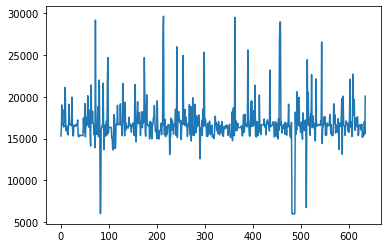

In [64]:
plt.plot(species_.dna.str.len())

In [111]:
# Agglomerative Hierarchical Clustering
Z = linkage(yd)

In [75]:
yd

[8498,
 9836,
 8806,
 8674,
 8788,
 7193,
 9142,
 7227,
 9786,
 8909,
 7664,
 7799,
 7646,
 8920,
 9879,
 9064,
 11228,
 7378,
 7501,
 7255,
 10086,
 10547,
 10053,
 11361,
 4079,
 4417,
 9218,
 9854,
 9390,
 11439,
 4555,
 9049,
 9747,
 9264,
 11277,
 9152,
 9852,
 9294,
 11287,
 9281,
 7364,
 8419,
 9679,
 10757,
 9219]

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [20.0, 20.0, 42.5, 42.5],
  [5.0, 5.0, 31.25, 31.25],
  [65.0, 65.0, 75.0, 75.0],
  [18.125, 18.125, 70.0, 70.0]],
 'dcoord': [[0.0, 2502.0, 2502.0, 0.0],
  [0.0, 3632.0, 3632.0, 0.0],
  [0.0, 4486.0, 4486.0, 3632.0],
  [2502.0, 4571.0, 4571.0, 4486.0],
  [0.0, 5932.0, 5932.0, 4571.0],
  [0.0, 225871.0, 225871.0, 0.0],
  [5932.0, 380220.0, 380220.0, 225871.0]],
 'ivl': ['7', '0', '1', '3', '2', '6', '4', '5'],
 'leaves': [7, 0, 1, 3, 2, 6, 4, 5],
 'color_list': ['C1', 'C1', 'C1', 'C1', 'C1', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C2', 'C2']}

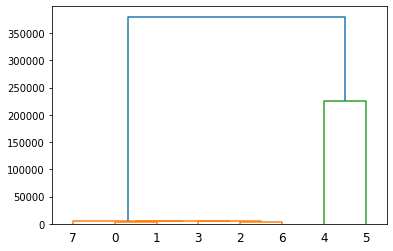

In [112]:
dendrogram(Z)

In [172]:
test = ['human', 'chimpanzee', 'dog', 'lion', 'Pacific walrus', 'rainbow trout', 'apple', 'tomato']

In [110]:
dnas = [species[species.name == x].dna.iloc[0] for x in test]

yd = []
for i, a in tqdm(enumerate(dnas)):
    for b in tqdm(dnas[i + 1:], leave=False):
        yd.append(distance(a, b))

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [191]:
yd_ = []
for i, a in tqdm(enumerate(dnas)):
    for b in tqdm(dnas[i + 1:], leave=False):
        yd_.append(abs(len(a) - len(b)))

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [193]:
ydc = []
for i, a in tqdm(enumerate(species.dna), total=len(species)):
    for b in species.dna.iloc[i + 1:]:
        ydc.append(abs(len(a) - len(b)))

  0%|          | 0/724 [00:00<?, ?it/s]

In [268]:
# Build partial matrix of Leveshtein distance, where length-distance < 1000
K_lev_ = np.full((len(species), len(species)), 1)
for i in trange(len(species)):
    for j in range(i, len(species)):#, leave=False):
        a, b = species.dna[i], species.dna[j]
        if len_distance(a, b) < 1000:
            K_lev_[i, j] = K_lev_[j, i] = 0 # levenshtein(a, b)

  0%|          | 0/724 [00:00<?, ?it/s]

In [274]:
# Build partial matrix of Leveshtein distance, where length-distance < 1000
K_len = np.full((len(species), len(species)), np.nan)
for i in trange(len(species)):
    for j in range(i, len(species)):
        a, b = species.dna[i], species.dna[j]
        K_len[i, j] = K_len[j, i] = len_distance(a, b)

  0%|          | 0/724 [00:00<?, ?it/s]

/var/folders/b_/mrq467b11bv_32fb0lz46bgm0000gp/T/ipykernel_66379/3010978147.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


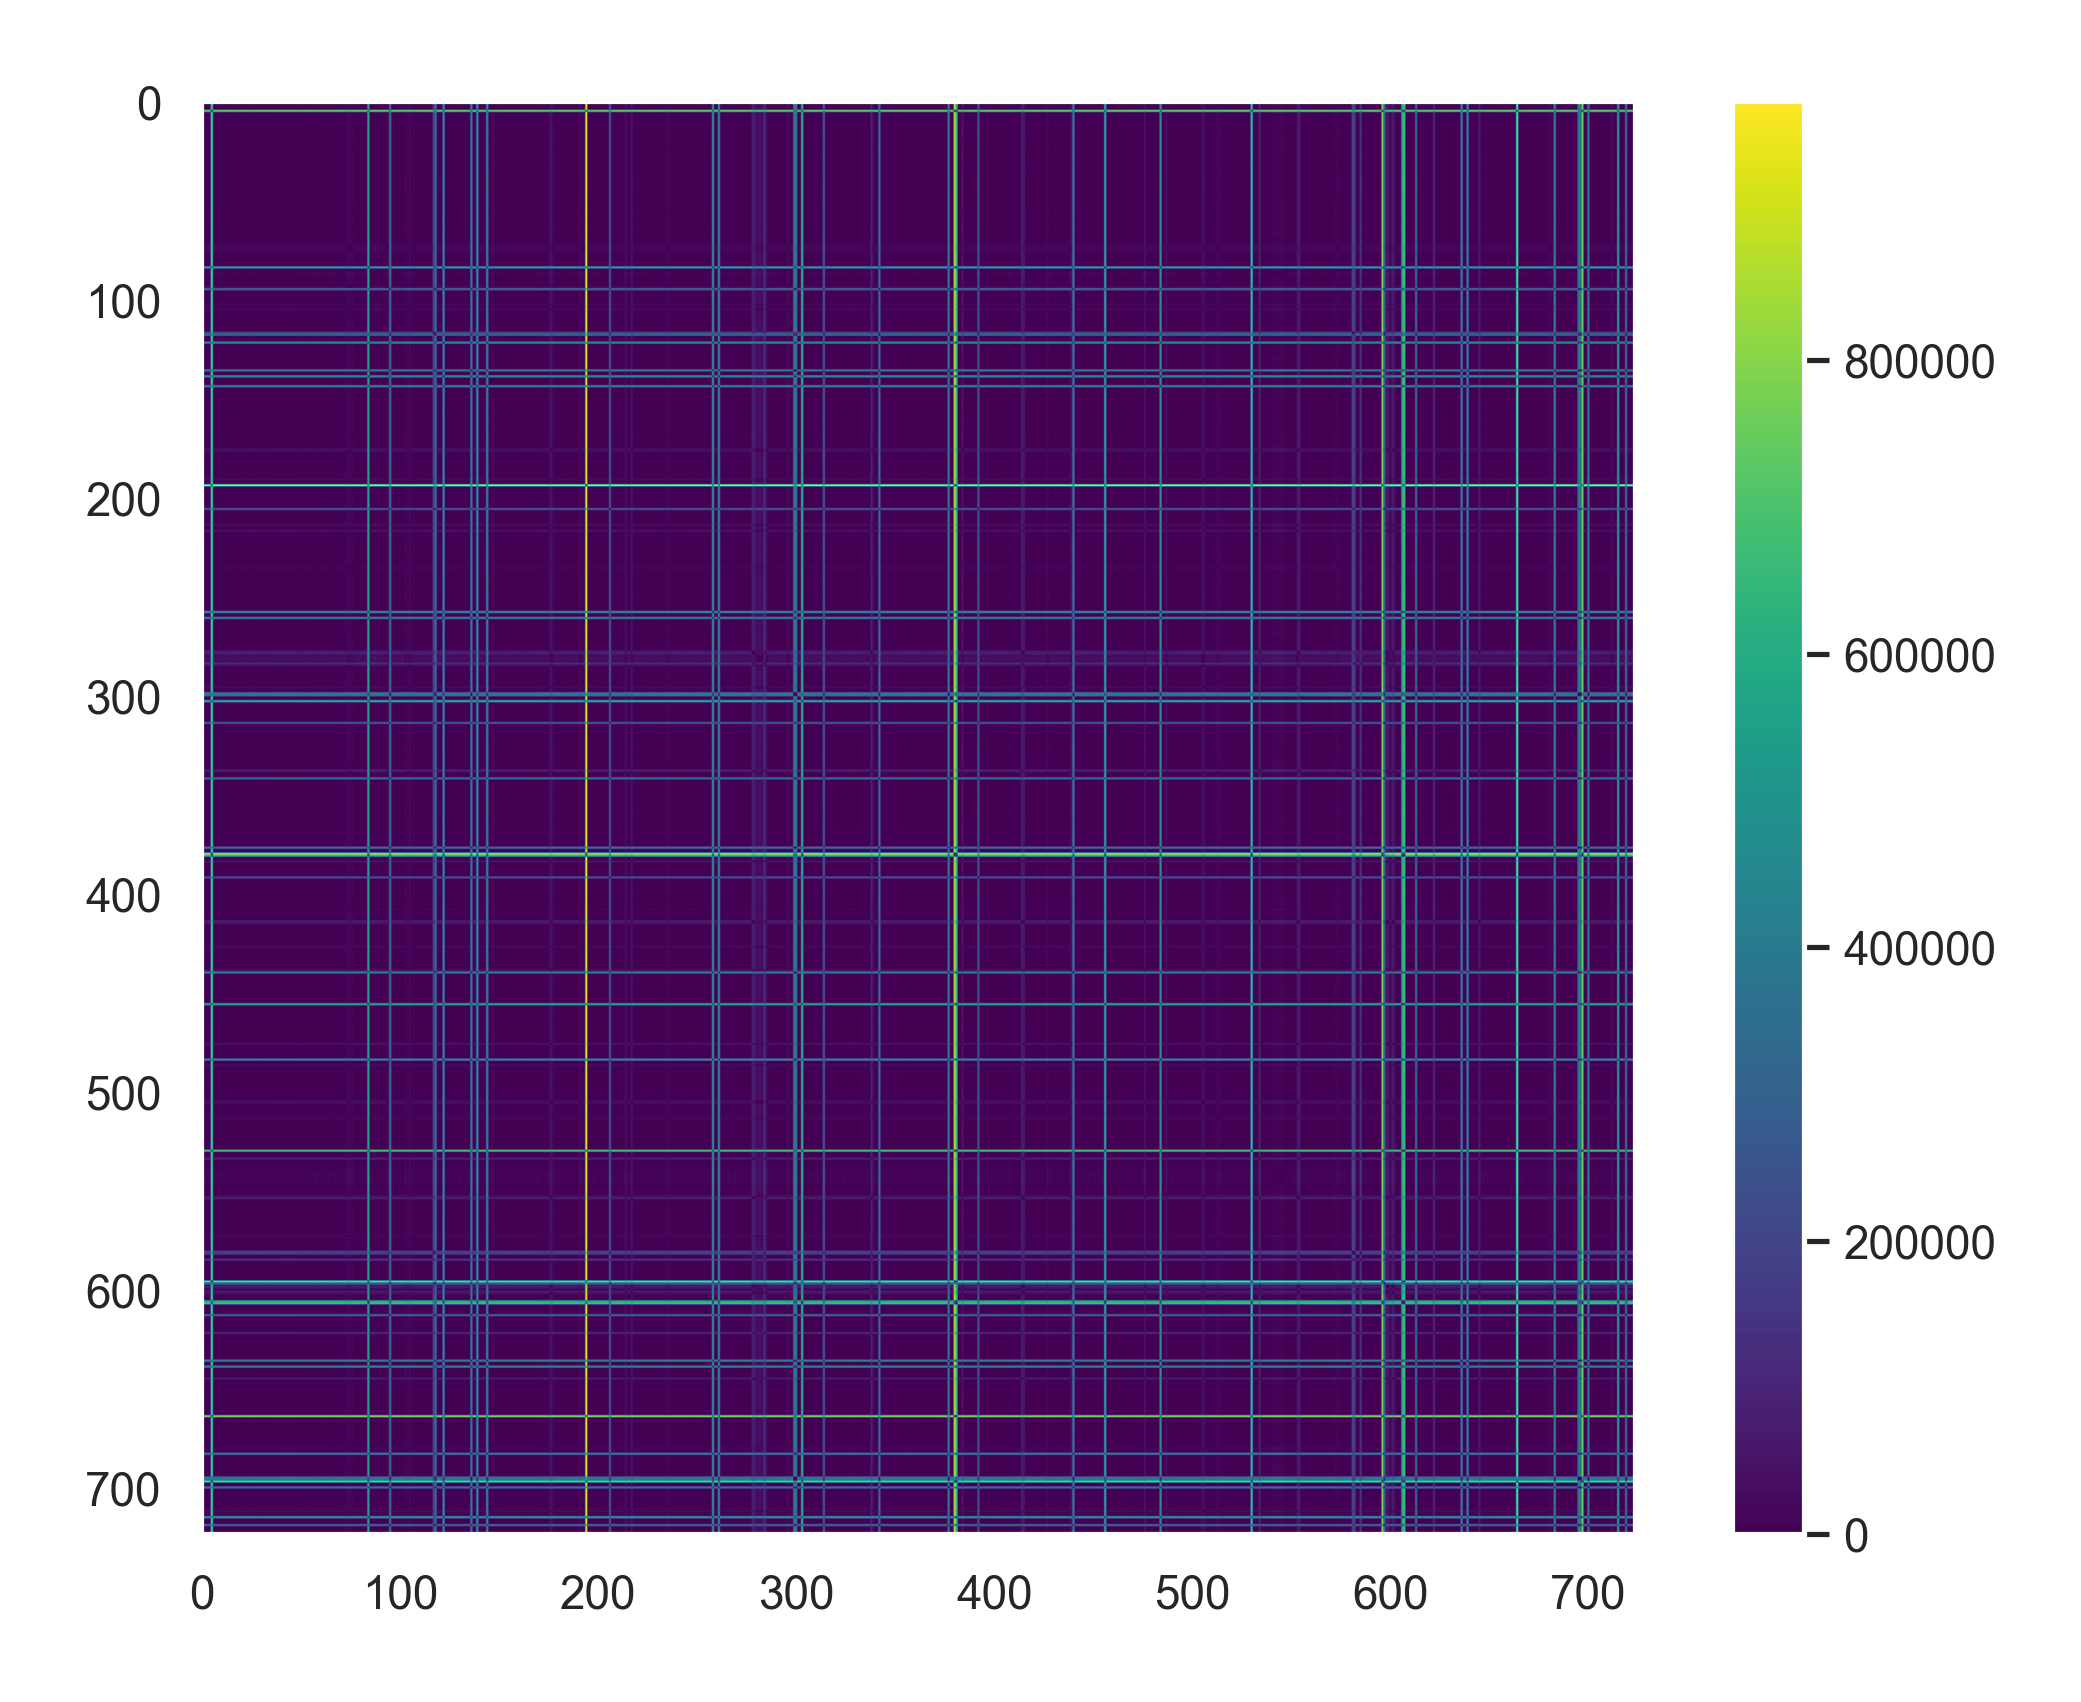

In [275]:
plt.imshow(K_len, cmap='viridis')
plt.grid(False)
plt.colorbar()

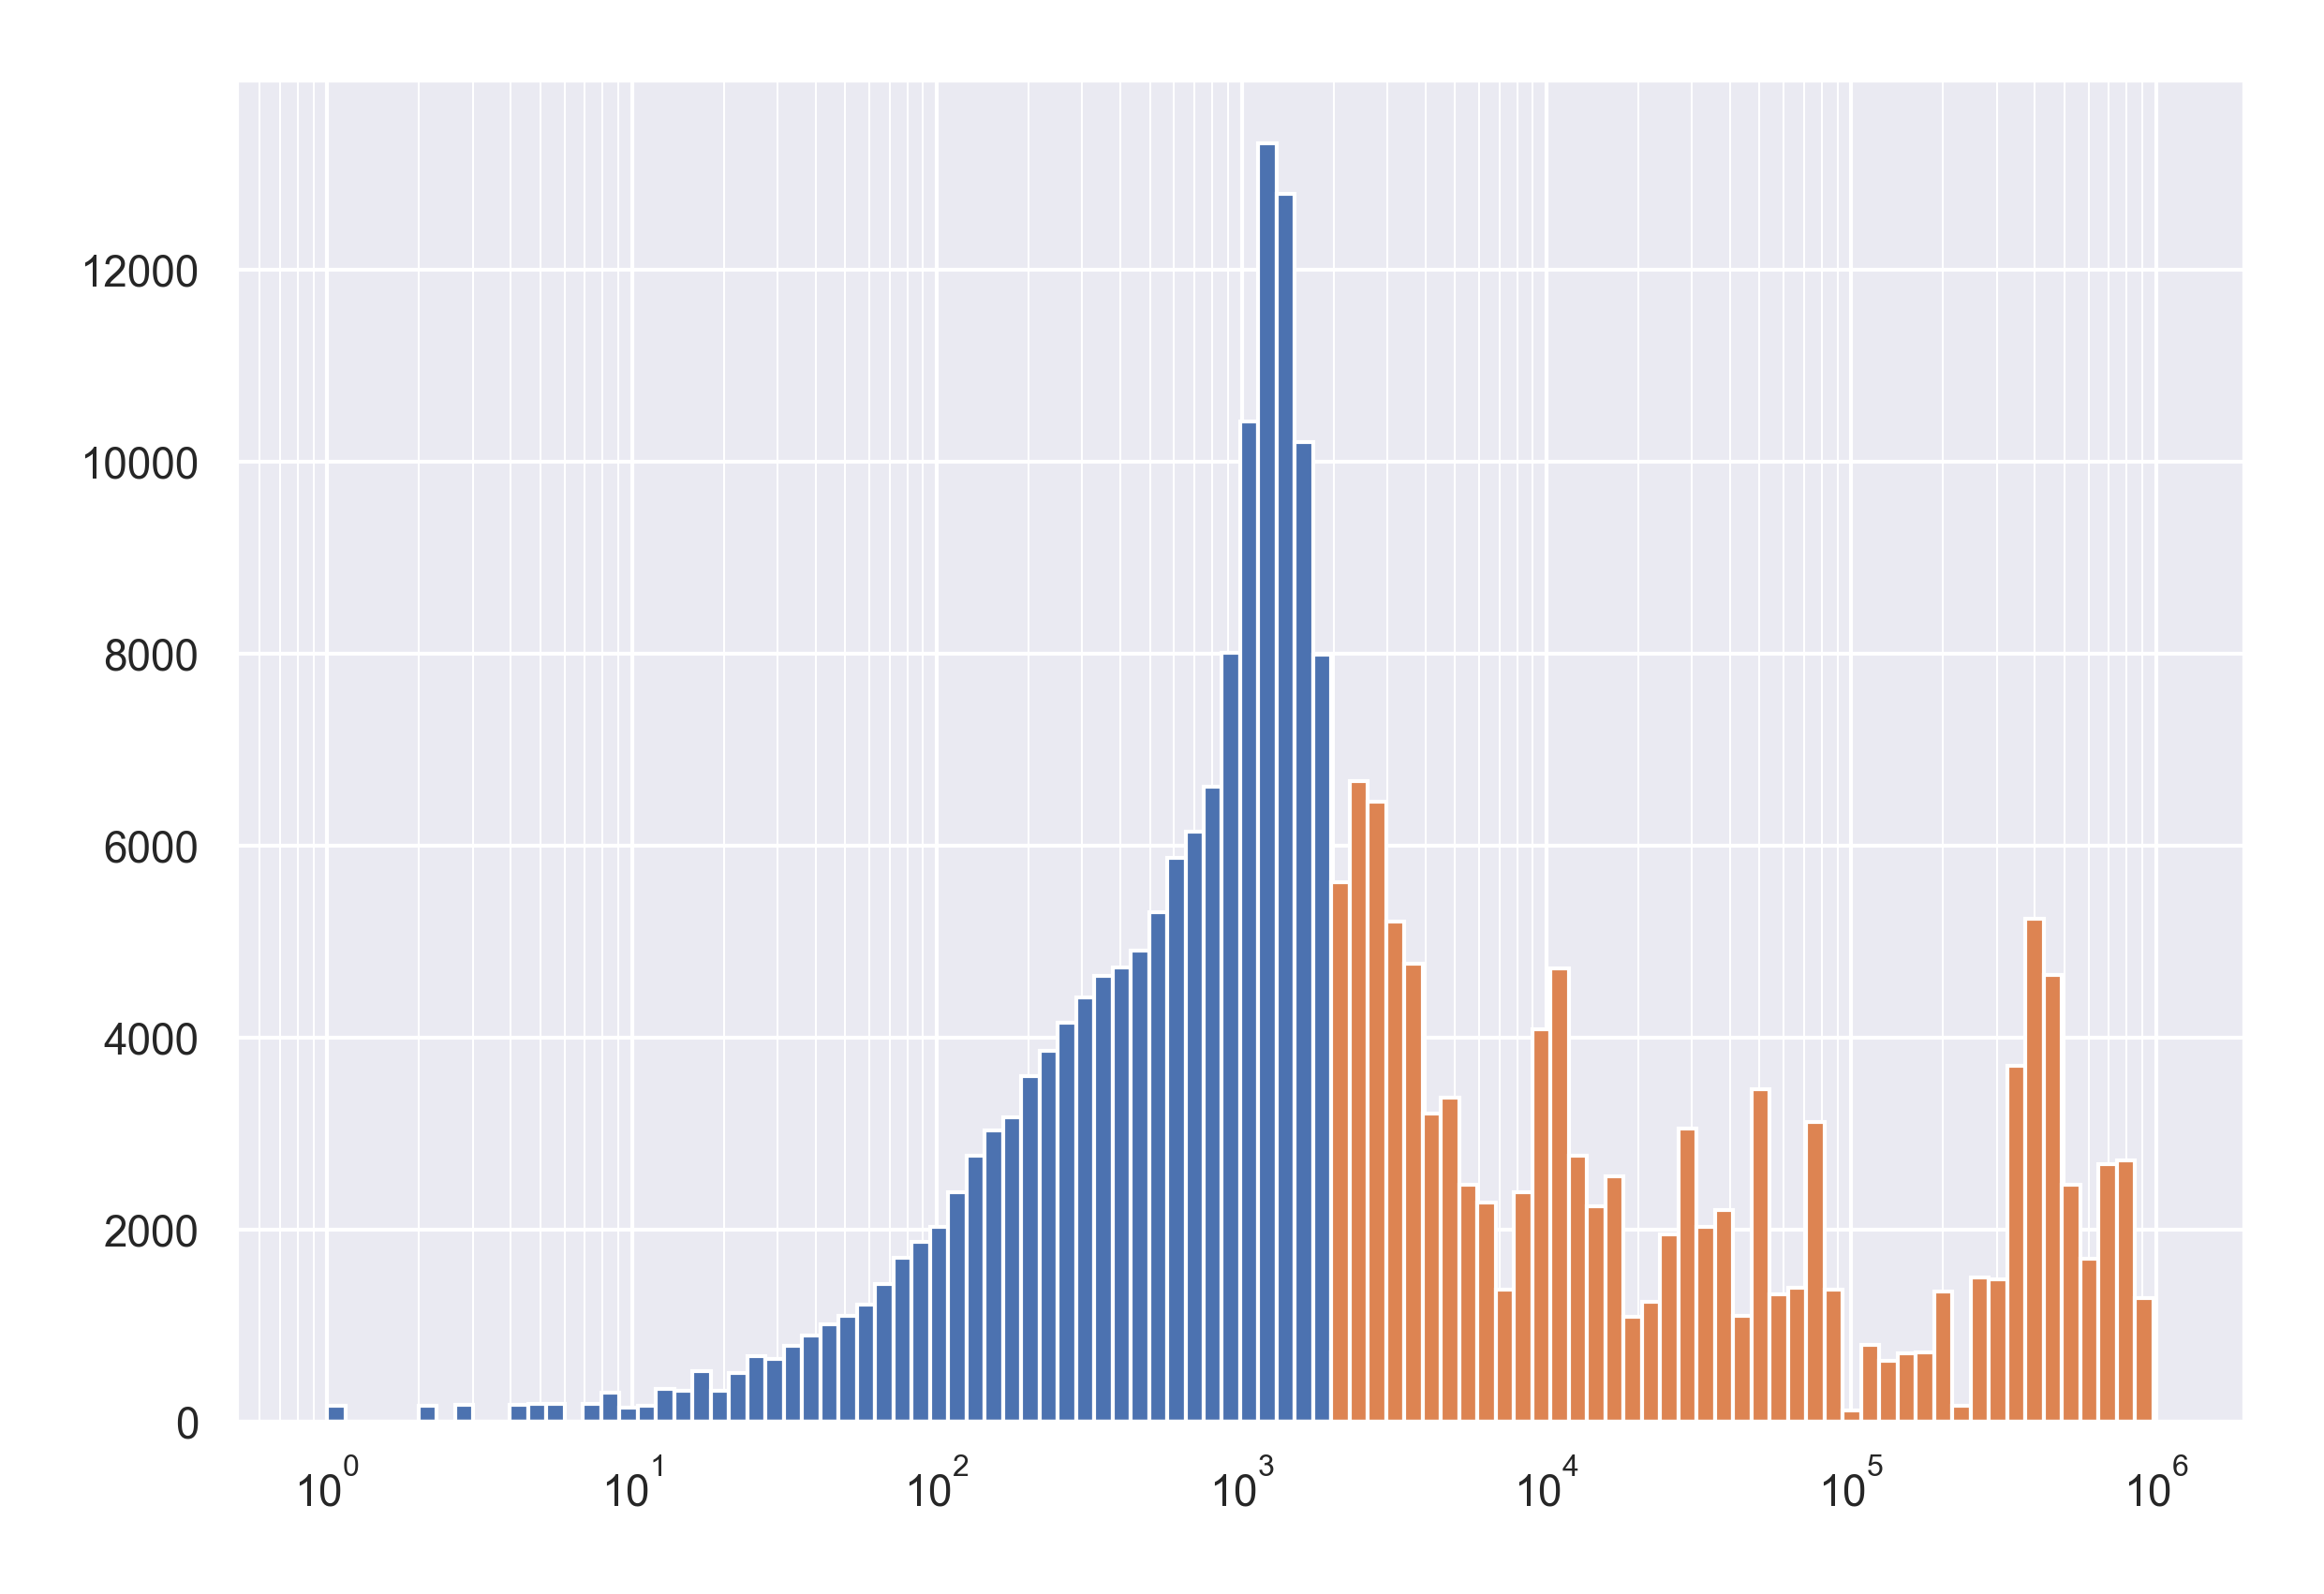

In [288]:
lens = K_len[np.triu_indices(len(K_lev), 1)]
lens = lens[lens > 0]
hist, bins, _ = plt.hist(lens, 100)
plt.close()

fig, ax = plt.subplots()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
ax.hist(lens[lens < 2000], bins=logbins)
ax.hist(lens[lens >= 2000], bins=logbins)
ax.set_xscale('log')
ax.xaxis.grid(which='minor', lw=0.5)
plt.show()

In [ ]:
# merging: calculate maximum distance in levenshtein (:= md). this is still with max. 2000 distance in len-dist.
# to merge, add md to all distances calculated in len-distance style.

In [284]:
K_len[np.triu_indices(len(K_lev), 1)]

976876.0

/var/folders/b_/mrq467b11bv_32fb0lz46bgm0000gp/T/ipykernel_66379/4122944191.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


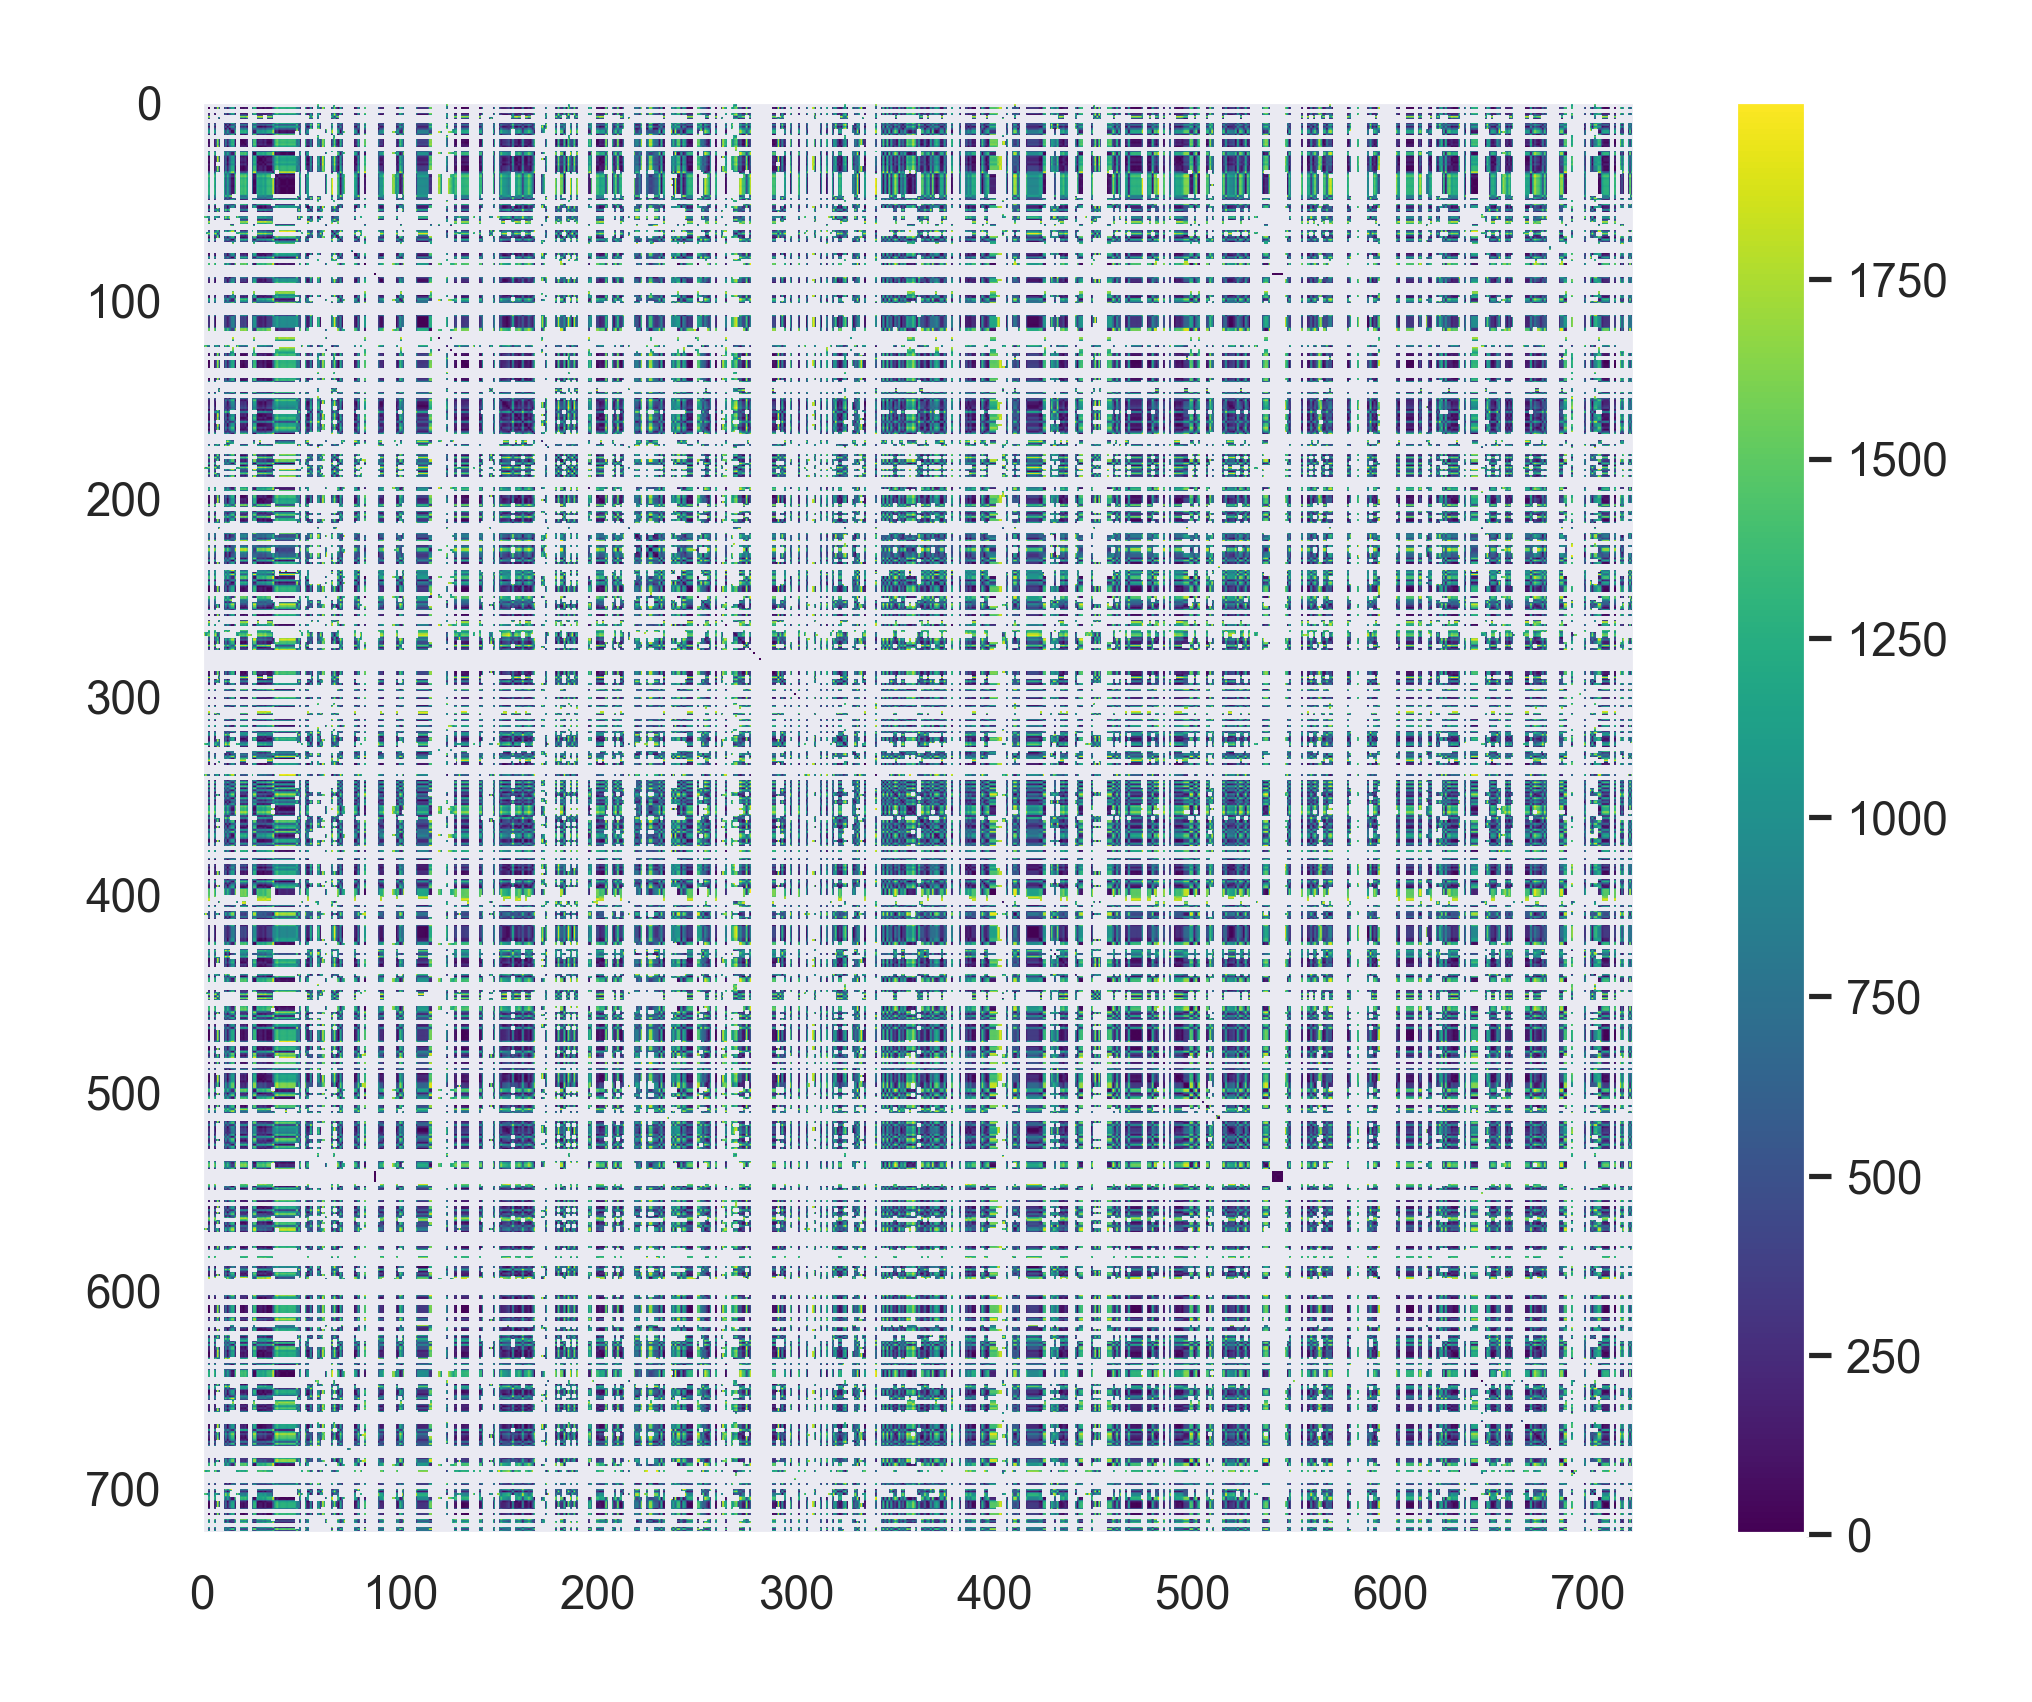

In [287]:
plt.imshow(np.where(K_len < 2000, K_len, np.nan), cmap='viridis')
plt.grid(False)
plt.colorbar()

In [ ]:
# Build partial matrix of Leveshtein distance, where length-distance < 1000
K_lev = np.full((len(species), len(species)), np.nan)
for i in trange(5, len(species)):
    a = species.dna[i]
    for j in trange(i, len(species), leave=False):
        b = species.dna[j]
        if K_len[i, j] < 2000:
            K_lev[i, j] = K_lev[j, i] = levenshtein(a, b)

  0%|          | 0/719 [00:00<?, ?it/s]

In [ ]:
print("hi")

In [313]:
K_len[1, 2]
a, b = species.dna[1], species.dna[2]
len_distance(a, b)
levenshtein(a, b)

8909

In [330]:
# old in K_lev_

In [314]:
len(a)

16234

In [323]:
np.nanargmax(K_lev)

4211

In [322]:
np.nanmax(K_lev)

420029.0

In [324]:
K_lev.ravel()[4211]

420029.0

In [325]:
K_len.ravel()[4211]

786859.0

In [326]:
np.unravel_index(4211, K_len.shape)

(5, 591)

In [327]:
a, b = species.dna[5], species.dna[591]

In [328]:
len_distance(a, b)

786859

In [329]:
levenshtein(a, b)

786859

In [321]:
K_lev

array([[  nan, 8498.,   nan, ...,   nan, 6974.,   nan],
       [  nan,   nan, 7664., ..., 8672.,   nan,   nan],
       [  nan,   nan, 7799., ...,   nan,   nan,   nan],
       ...,
       [  nan, 6974.,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

In [267]:
K_lev_

array([[ 1.,  1., nan, ..., nan,  1., nan],
       [ 1.,  1., nan, ...,  1.,  1., nan],
       [nan, nan,  1., ..., nan, nan, nan],
       ...,
       [nan,  1., nan, ...,  1., nan, nan],
       [ 1.,  1., nan, ..., nan,  1., nan],
       [nan, nan, nan, ..., nan, nan,  1.]])

In [256]:
K_lev[5]

array([    nan,   8920.,  10547.,   9390.,     nan,     nan,   8914.,
         2781.,     nan,     nan,     nan,   8561.,     nan,   9038.,
         8675.,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     

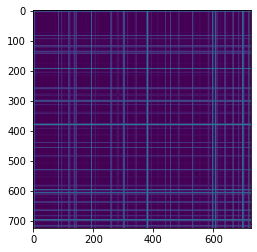

In [116]:
plt.imshow(K)

In [119]:
np.arange(16).reshape(4, 4)[np.triu_indices(4, 1)]

array([ 1,  2,  3,  6,  7, 11])

In [121]:
yd3 = K[np.triu_indices(len(K), 1)]
Z3 = linkage(yd3)

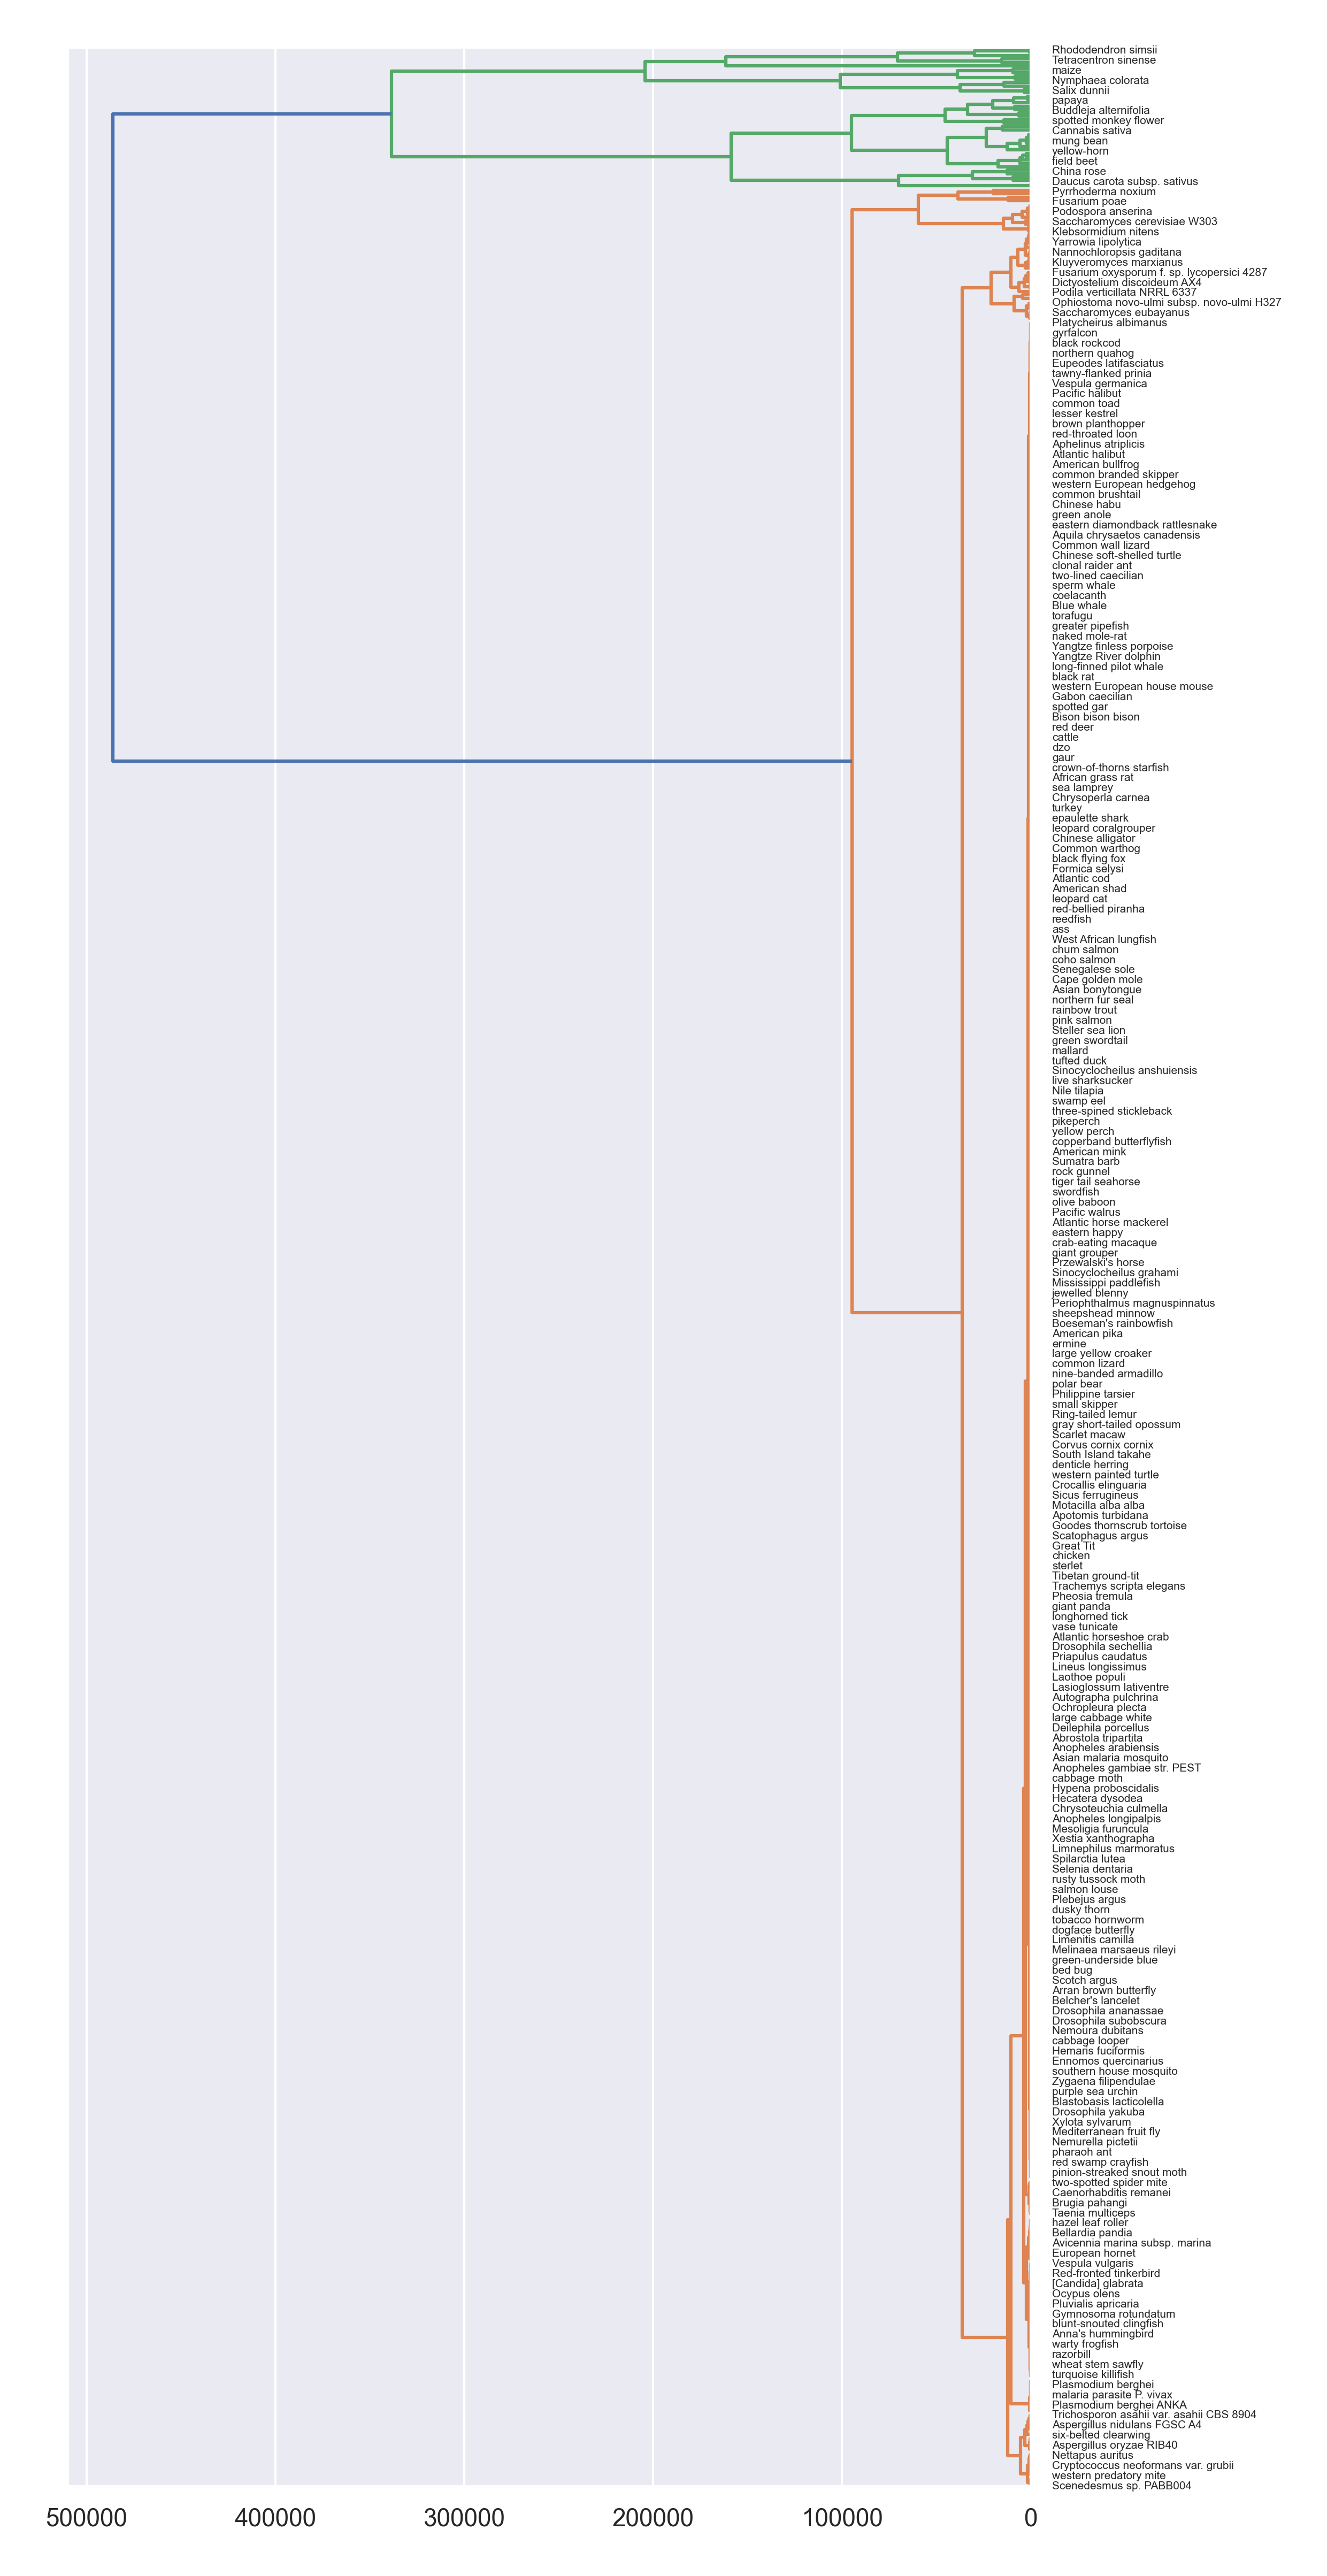

In [227]:
# Zc = linkage(ydc, 'average')

def llf(x, R):
    """Return label of x if x supposed to be displayed."""
    if R['ivl'].index(str(x)) % 3 == 0:
        return species.name.iloc[x]
    else:
        return ""

fig, ax = plt.subplots(figsize=(W, 2*W))
R = dendrogram(Zc, no_plot=True)
R = dendrogram(Zc, orientation='left', ax=ax, leaf_label_func=lambda x: llf(x, R))#, labels=species.name.to_list())
ax.yaxis.grid(False)
#ax.set_xscale('log')
plt.show()

In [246]:
def distance(a, b):
    d = abs(len(a) - len(b))
    if d > 1000:
        return d
    else:
        return levenshtein(a, b)

In [249]:
def len_distance(a, b):
    return abs(len(a) - len(b))

In [225]:
Zc2 = Zc.copy()
Zc2[:, 2] += 100000
Zc2

array([[3.00000000e+00, 4.72000000e+02, 1.00000000e+05, 2.00000000e+00],
       [4.00000000e+00, 3.89000000e+02, 1.00000000e+05, 2.00000000e+00],
       [6.00000000e+00, 1.10000000e+01, 1.00000000e+05, 2.00000000e+00],
       ...,
       [1.44100000e+03, 1.44300000e+03, 3.04188375e+05, 1.40000000e+01],
       [1.44200000e+03, 1.44400000e+03, 4.38402536e+05, 4.20000000e+01],
       [1.43900000e+03, 1.44500000e+03, 5.85880369e+05, 7.24000000e+02]])

In [212]:
R['ivl'].index('596')

723

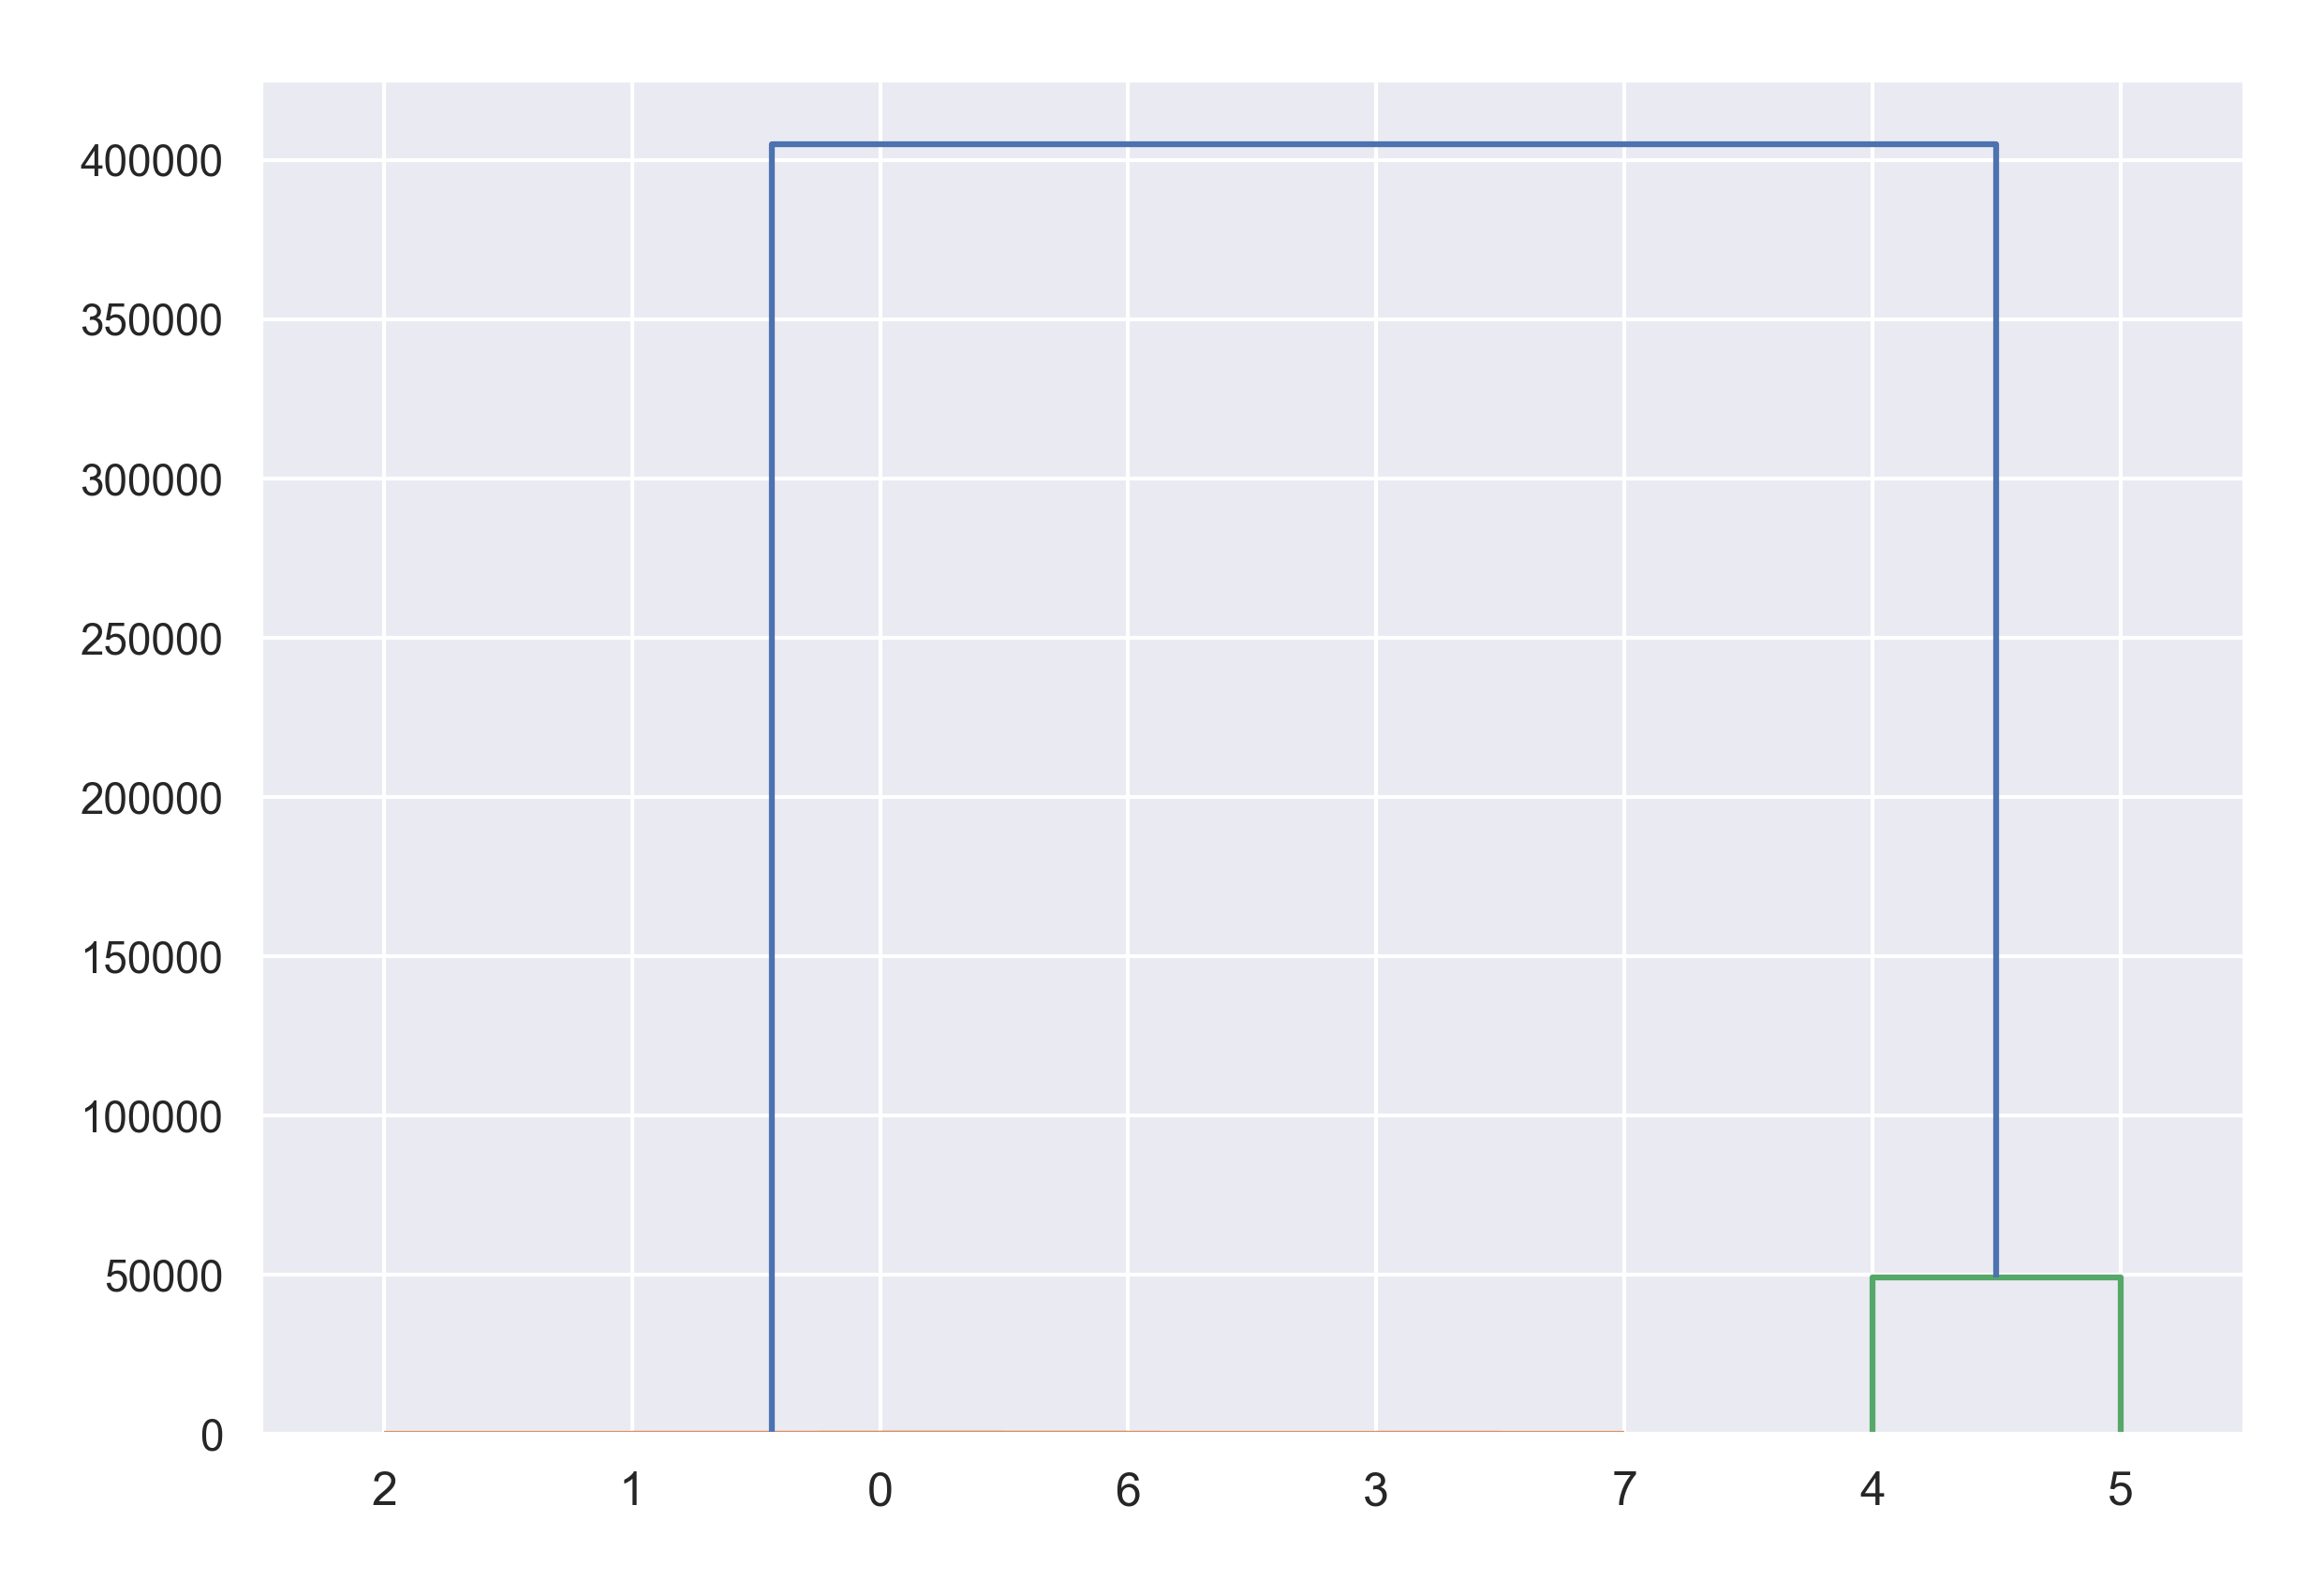

In [201]:
Z_ = linkage(yd_, 'average')
dendrogram(Z_)#, labels=species.name.to_list())
plt.show()

In [182]:
Zc.shape

(724, 4)

In [142]:
Z2

array([[0.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00],
       [1.0000e+00, 5.0000e+00, 1.1000e+01, 3.0000e+00],
       [3.0000e+00, 4.0000e+00, 2.2000e+01, 2.0000e+00],
       [6.0000e+00, 7.0000e+00, 5.1000e+01, 5.0000e+00],
       [2.0000e+00, 8.0000e+00, 8.5000e+01, 6.0000e+00],
       [4.0000e+00, 5.0000e+00, 4.9310e+04, 2.0000e+00],
       [1.2000e+01, 1.3000e+01, 3.8022e+05, 8.0000e+00]])

In [144]:
Z2_ = Z2[:-2].copy()

for i in range(len(Z2_)):
    for j in range(2):
        if Z2_[i, j] > 4:
            Z2_[i, j] -= 2

In [145]:
Z2_

array([[ 0.,  4.,  4.,  2.],
       [ 1.,  6., 11.,  3.],
       [ 3.,  5., 22.,  2.],
       [ 7.,  8., 51.,  5.],
       [ 2.,  9., 85.,  6.]])

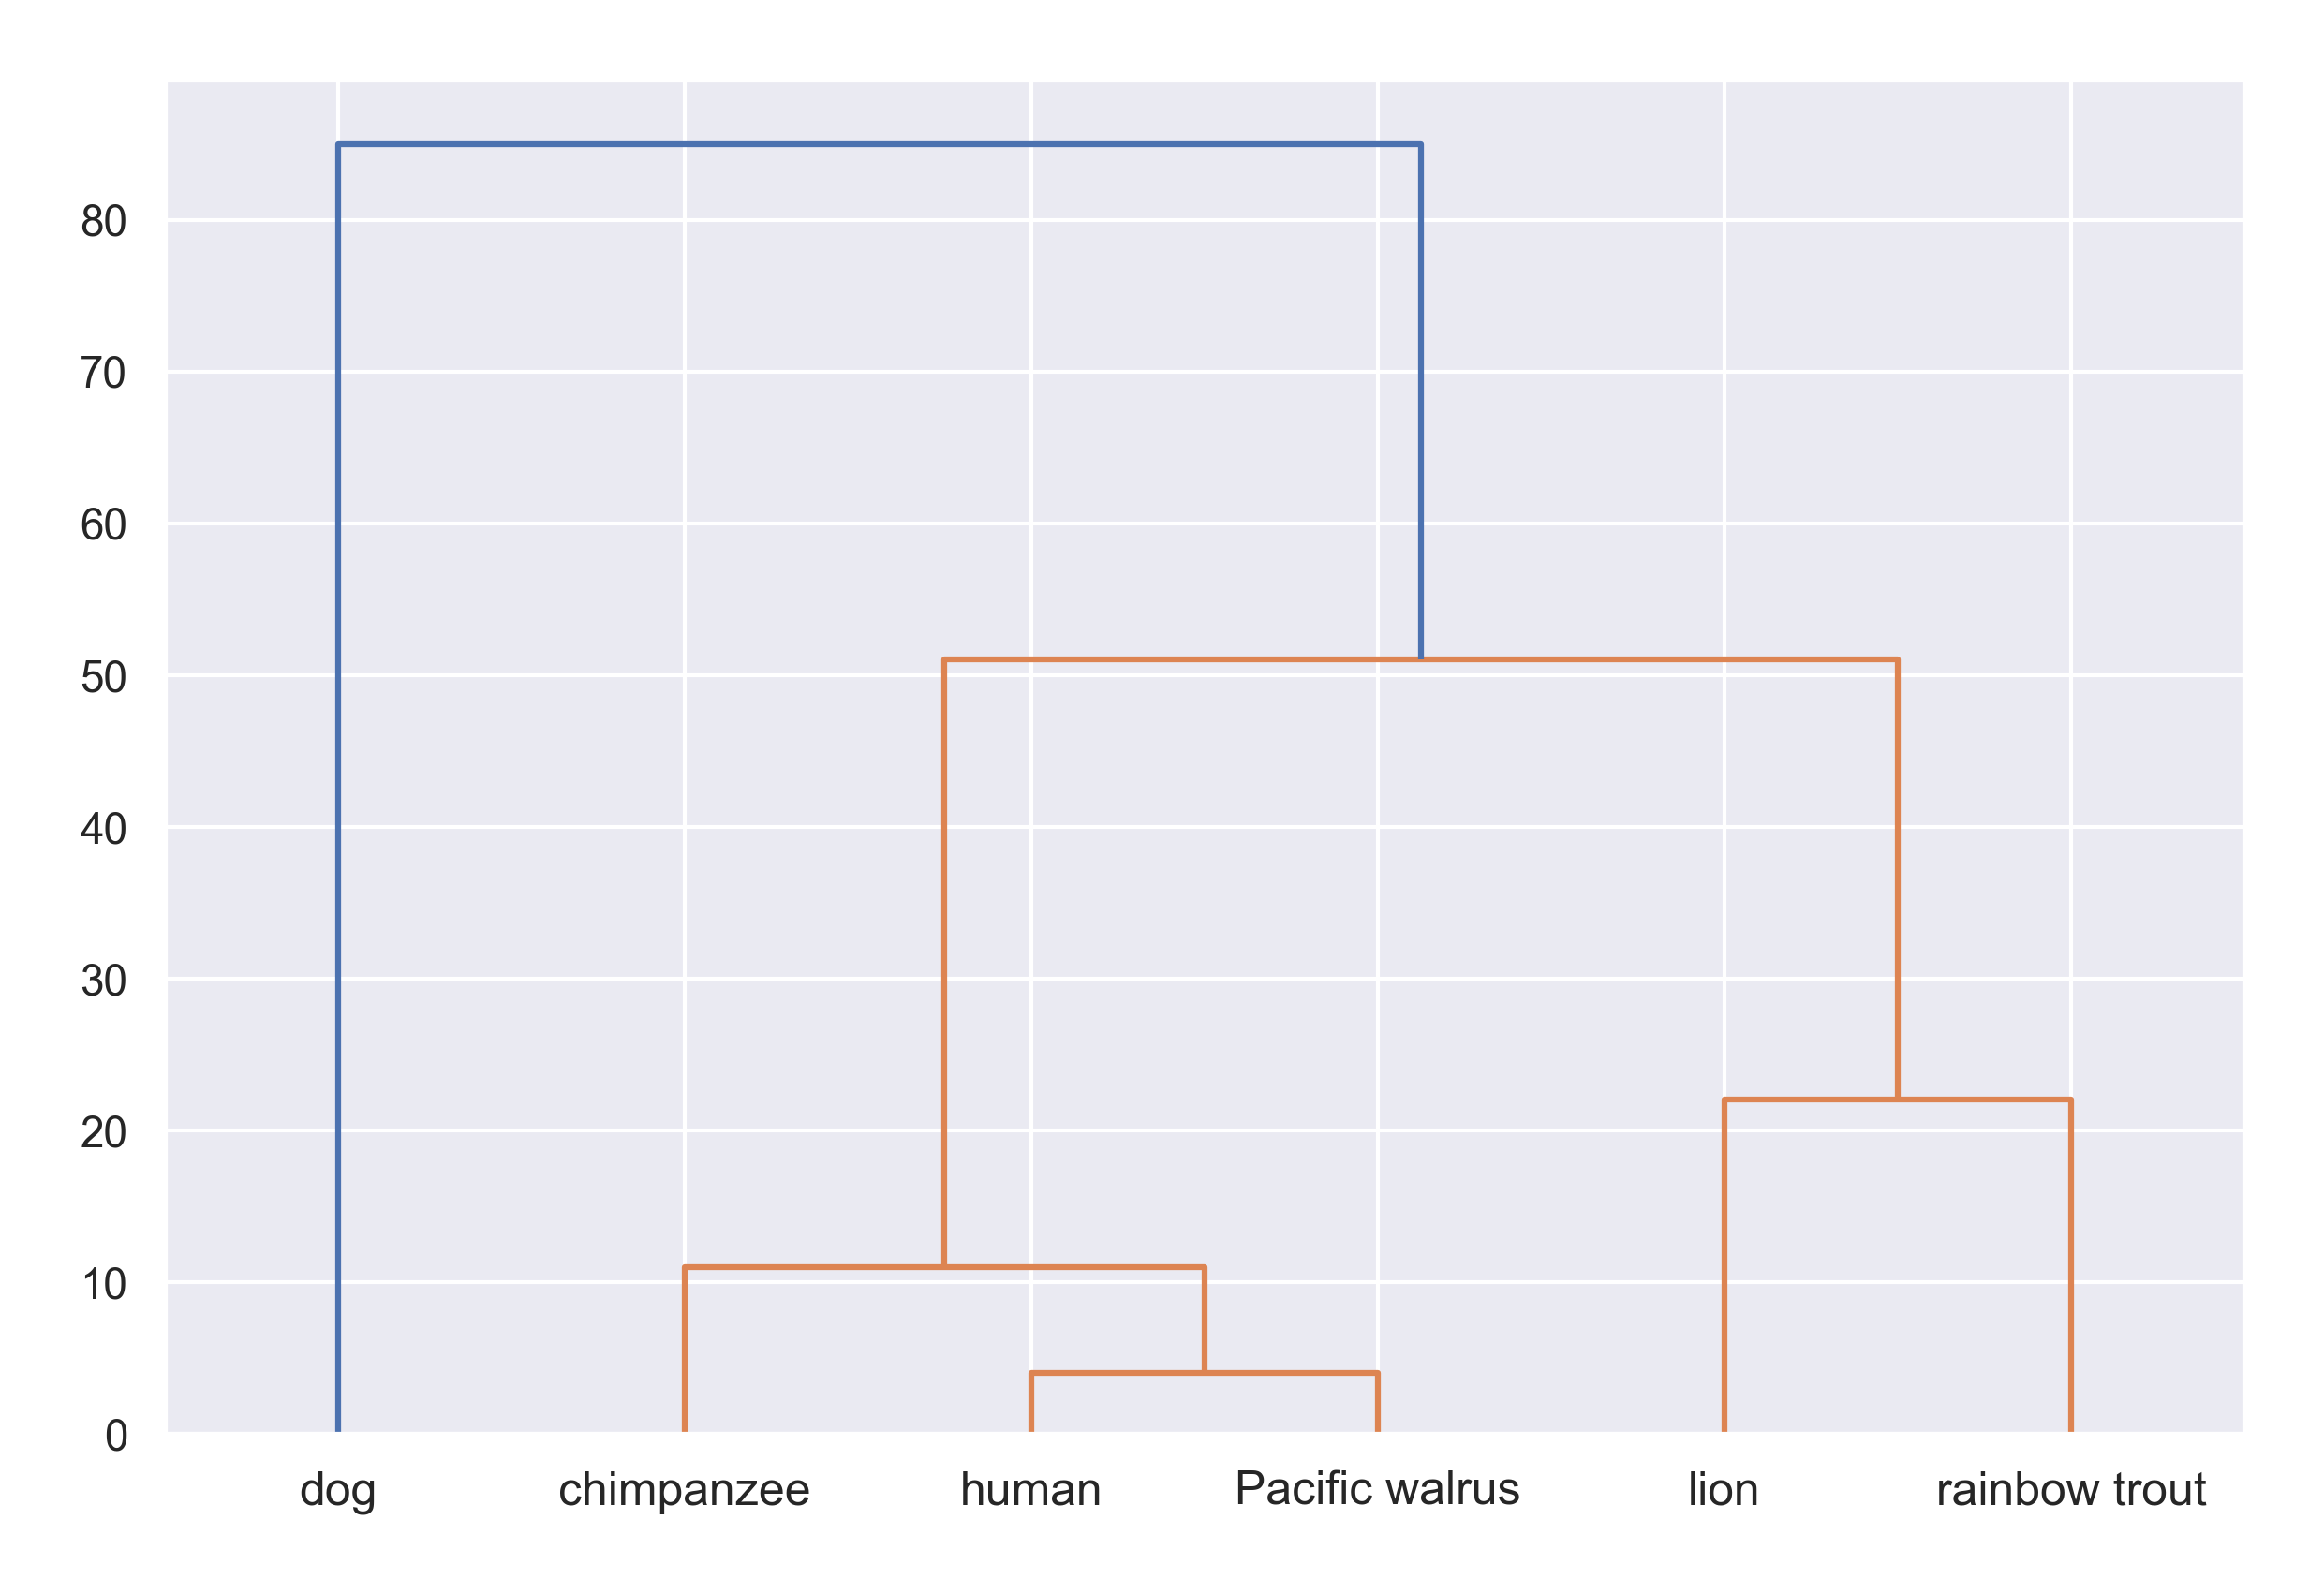

In [153]:
dendrogram(Z2_, labels=test_)
plt.show()

In [113]:
yd2 = []
for i, a in tqdm(enumerate(dnas)):
    for b in tqdm(dnas[i + 1:], leave=False):
        yd2.append(abs(len(a) - len(b)))

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [20.0, 20.0, 42.5, 42.5],
  [5.0, 5.0, 31.25, 31.25],
  [65.0, 65.0, 75.0, 75.0],
  [18.125, 18.125, 70.0, 70.0]],
 'dcoord': [[0.0, 2502.0, 2502.0, 0.0],
  [0.0, 3632.0, 3632.0, 0.0],
  [0.0, 4486.0, 4486.0, 3632.0],
  [2502.0, 4571.0, 4571.0, 4486.0],
  [0.0, 5932.0, 5932.0, 4571.0],
  [0.0, 225871.0, 225871.0, 0.0],
  [5932.0, 380220.0, 380220.0, 225871.0]],
 'ivl': ['rainbow trout',
  'human',
  'chimpanzee',
  'lion',
  'dog',
  'Pacific walrus',
  'apple',
  'tomato'],
 'leaves': [7, 0, 1, 3, 2, 6, 4, 5],
 'color_list': ['C1', 'C1', 'C1', 'C1', 'C1', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C2', 'C2']}

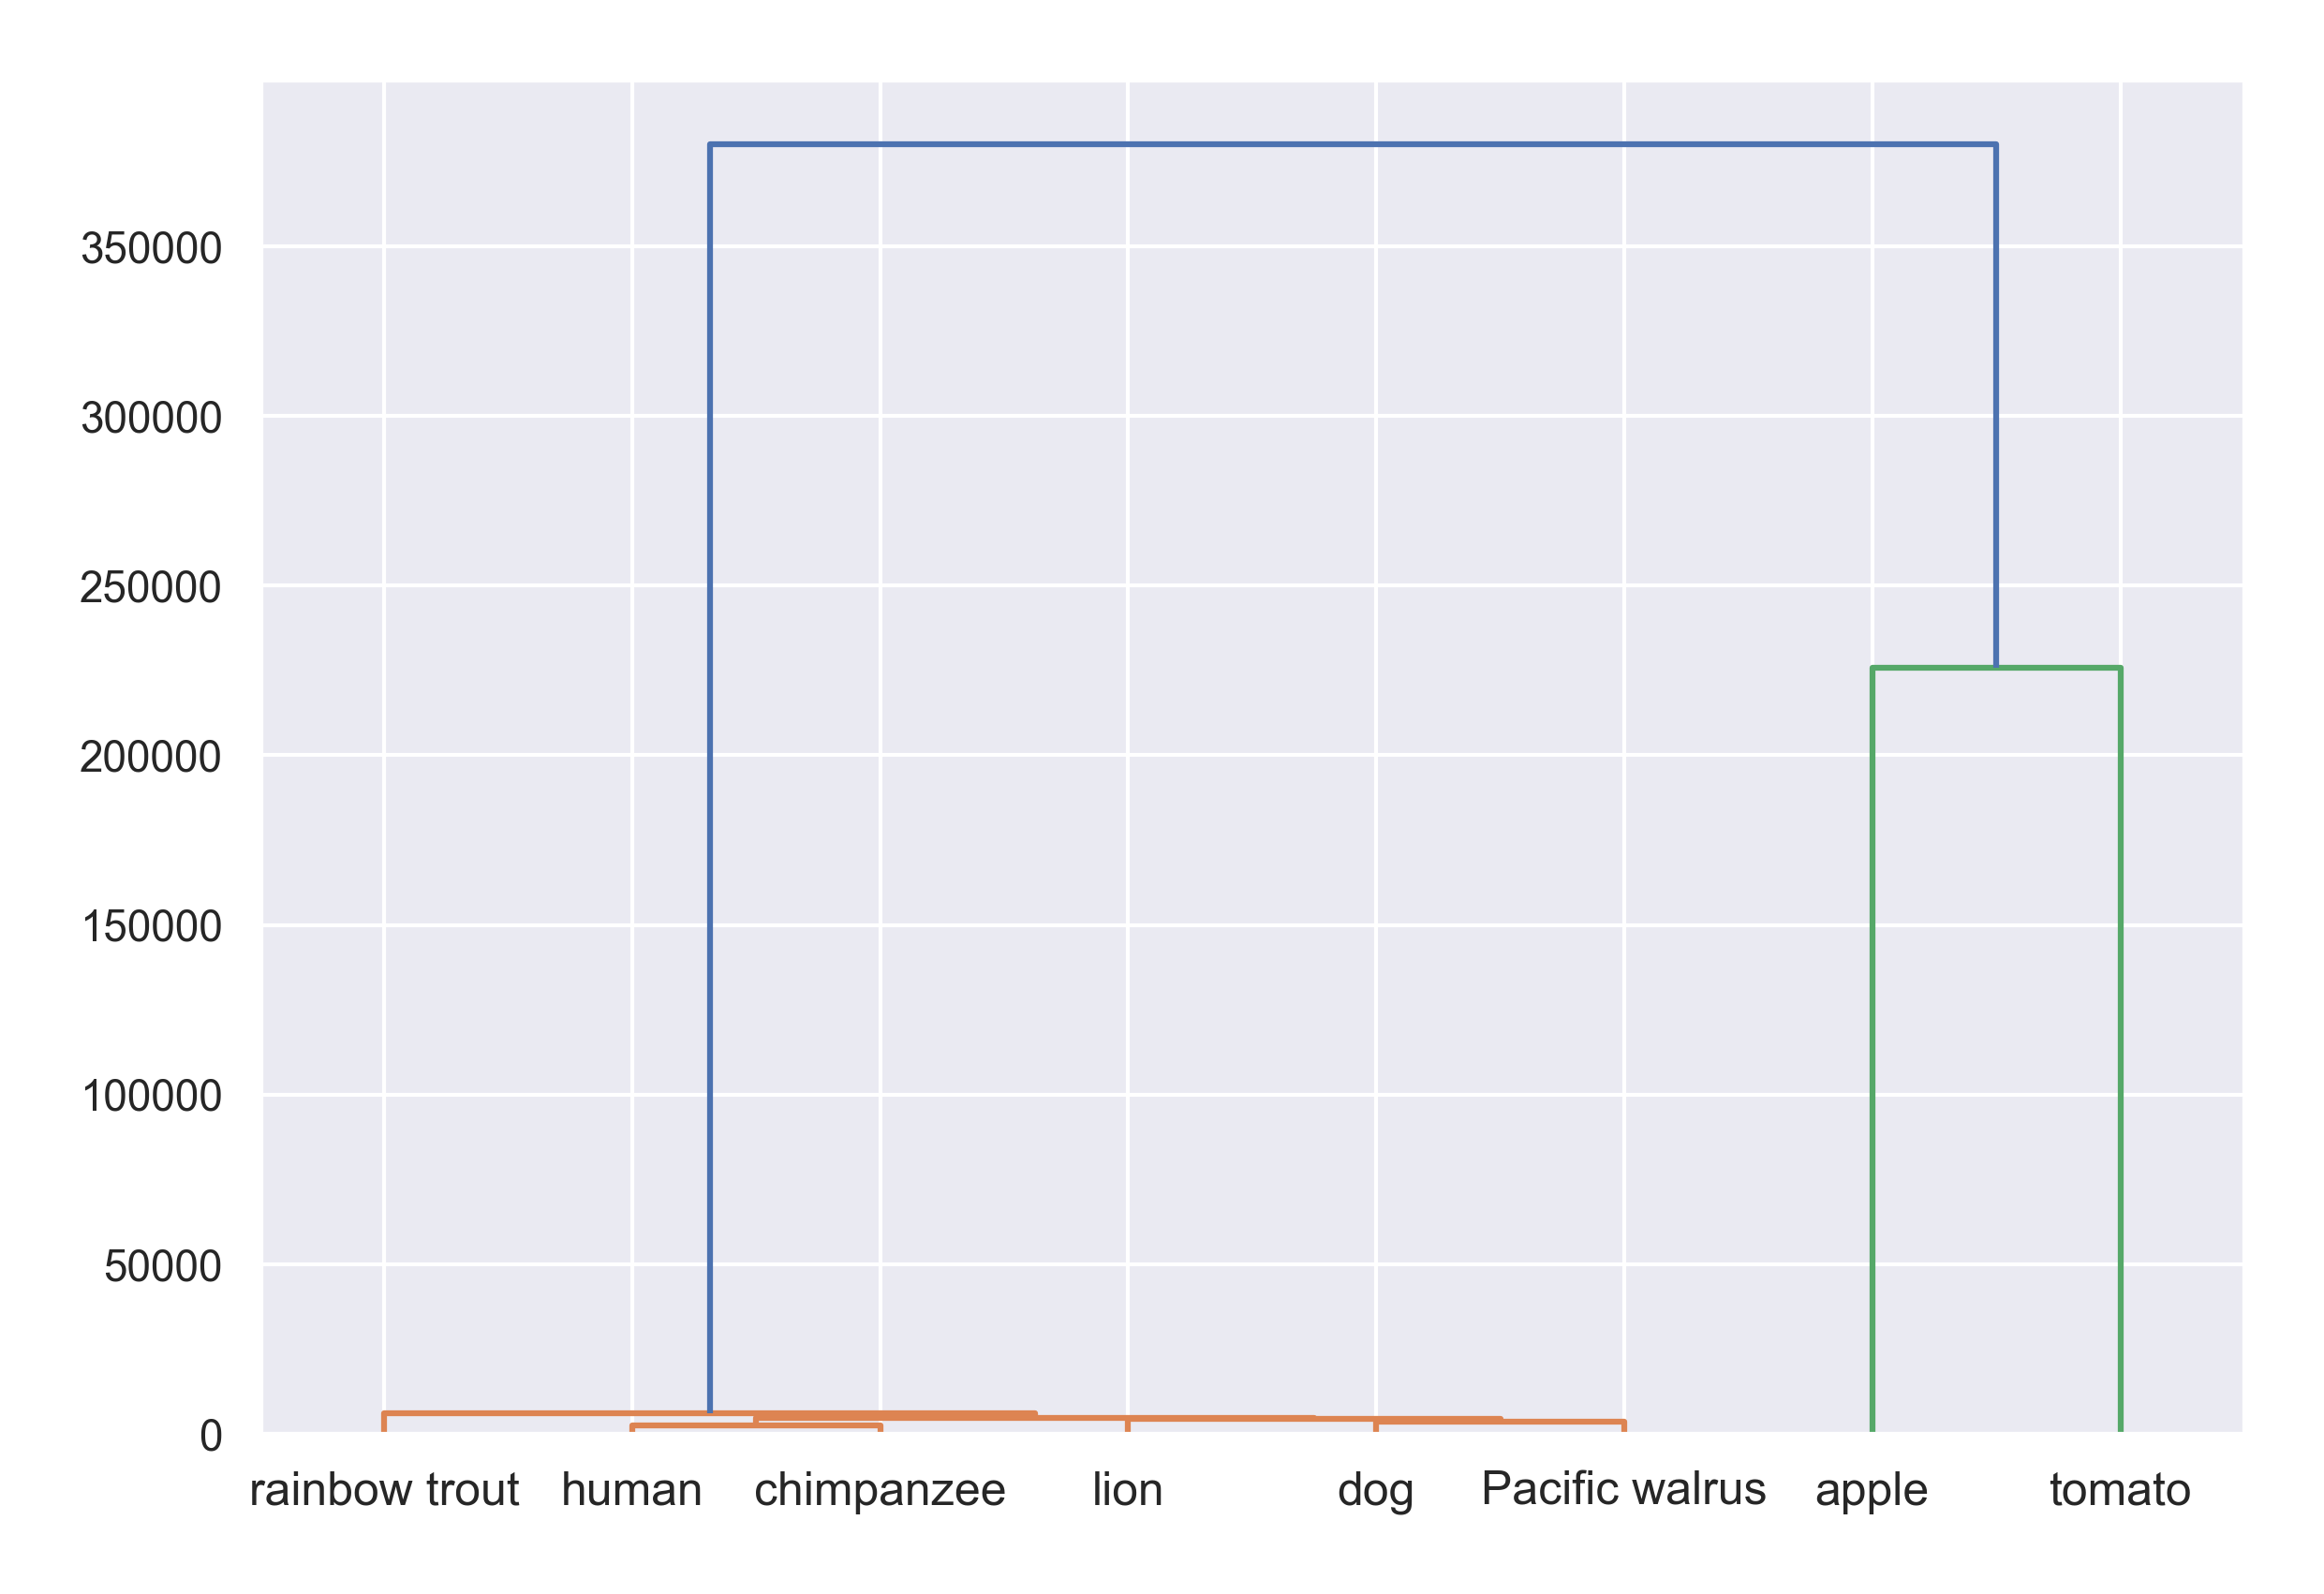

In [155]:
dendrogram(Z, labels=test)

In [148]:
Z_ = Z[:-2].copy()

for i in range(len(Z_)):
    for j in range(2):
        if Z_[i, j] > 4:
            Z_[i, j] -= 2

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [20.0, 20.0, 42.5, 42.5],
  [5.0, 5.0, 31.25, 31.25]],
 'dcoord': [[0.0, 2502.0, 2502.0, 0.0],
  [0.0, 3632.0, 3632.0, 0.0],
  [0.0, 4486.0, 4486.0, 3632.0],
  [2502.0, 4571.0, 4571.0, 4486.0],
  [0.0, 5932.0, 5932.0, 4571.0]],
 'ivl': ['rainbow trout',
  'human',
  'chimpanzee',
  'lion',
  'dog',
  'Pacific walrus'],
 'leaves': [5, 0, 1, 3, 2, 4],
 'color_list': ['C1', 'C2', 'C0', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C0', 'C2', 'C2']}

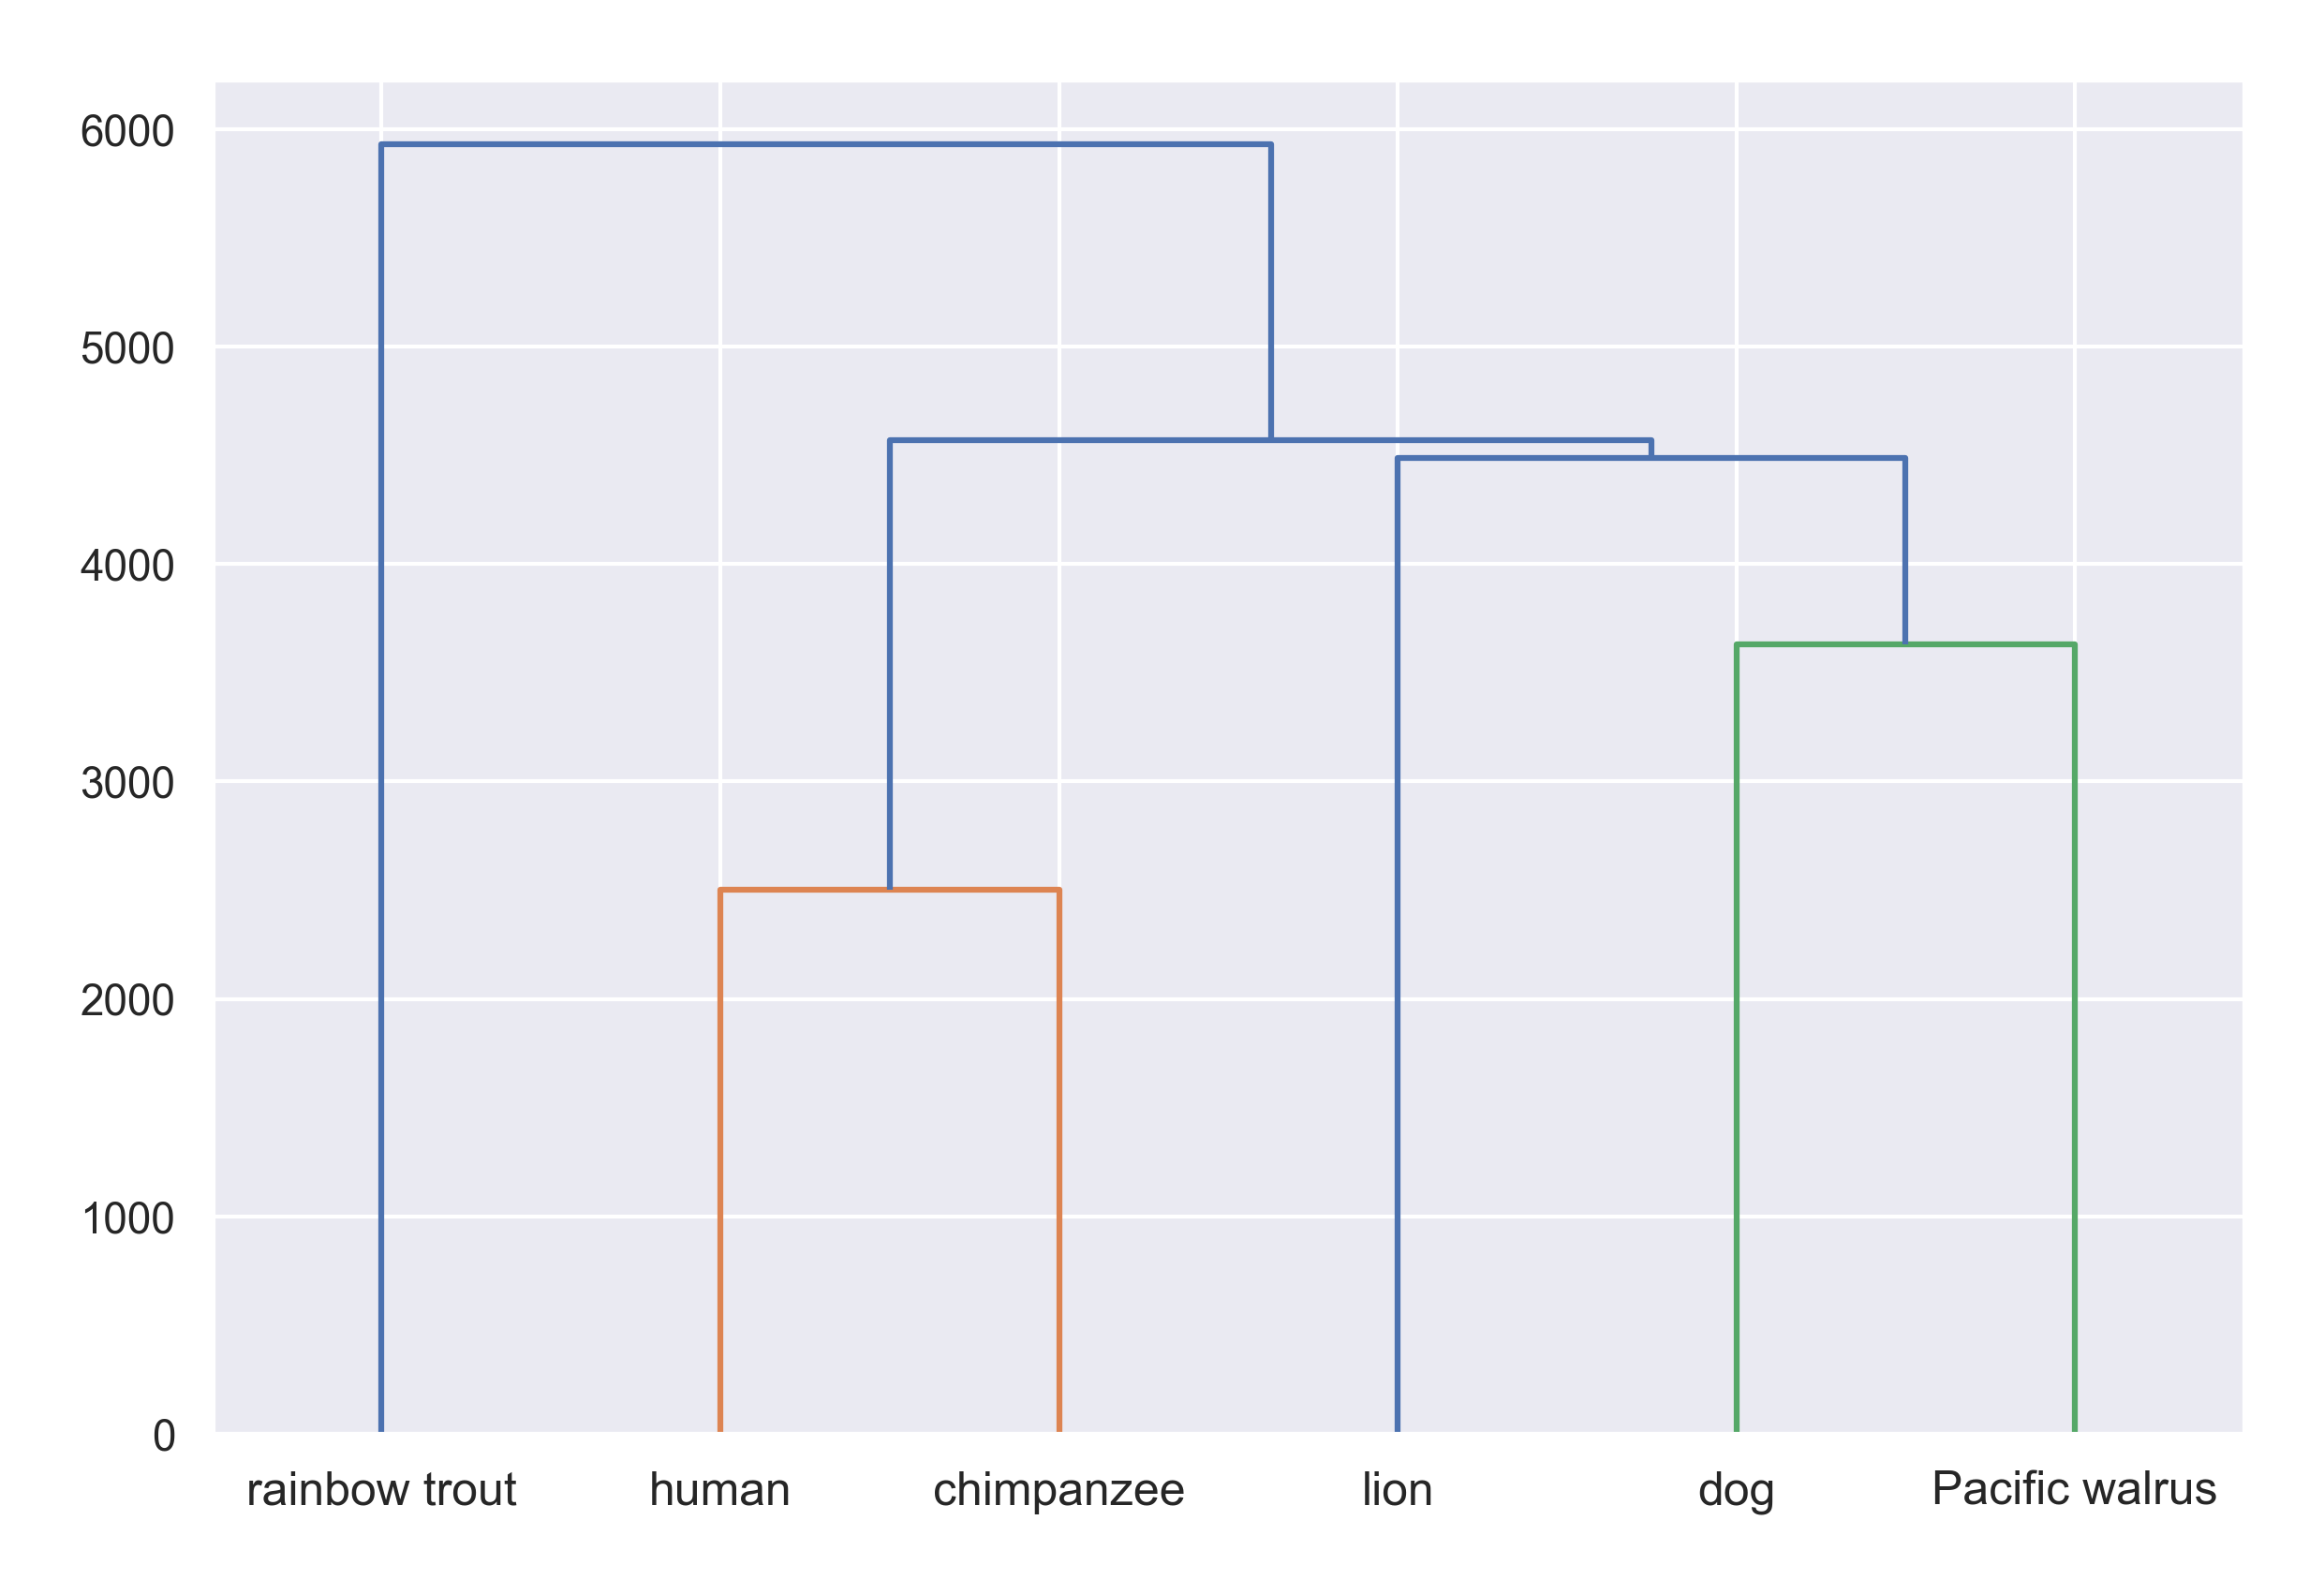

In [154]:
dendrogram(Z_, labels=test_)

above completely coincides with known taxonomy! dogs and walruses are "dog-like" carnivoria and lions are "cat-like" carnivoria. humans and chimpanzees are not carnivoria, but primates and trouts are fish.

In [159]:
hierarchy.cut_tree(Z)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 0, 0, 0, 0],
       [3, 2, 2, 1, 0, 0, 0, 0],
       [4, 3, 3, 2, 1, 1, 1, 0],
       [5, 4, 4, 3, 2, 2, 1, 0],
       [6, 5, 1, 1, 0, 0, 0, 0],
       [7, 6, 5, 4, 3, 0, 0, 0]])

In [164]:
hierarchy.fcluster(Z, 6000, 'distance')

array([1, 1, 1, 1, 2, 3, 1, 1], dtype=int32)

In [158]:
from scipy.cluster import hierarchy

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [22.5, 22.5, 50.0, 50.0],
  [5.0, 5.0, 36.25, 36.25],
  [65.0, 65.0, 75.0, 75.0],
  [20.625, 20.625, 70.0, 70.0]],
 'dcoord': [[0.0, 4.0, 4.0, 0.0],
  [0.0, 11.0, 11.0, 4.0],
  [0.0, 22.0, 22.0, 0.0],
  [11.0, 51.0, 51.0, 22.0],
  [0.0, 85.0, 85.0, 51.0],
  [0.0, 49310.0, 49310.0, 0.0],
  [85.0, 380220.0, 380220.0, 49310.0]],
 'ivl': ['2', '1', '0', '6', '3', '7', '4', '5'],
 'leaves': [2, 1, 0, 6, 3, 7, 4, 5],
 'color_list': ['C1', 'C1', 'C1', 'C1', 'C1', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C2', 'C2']}

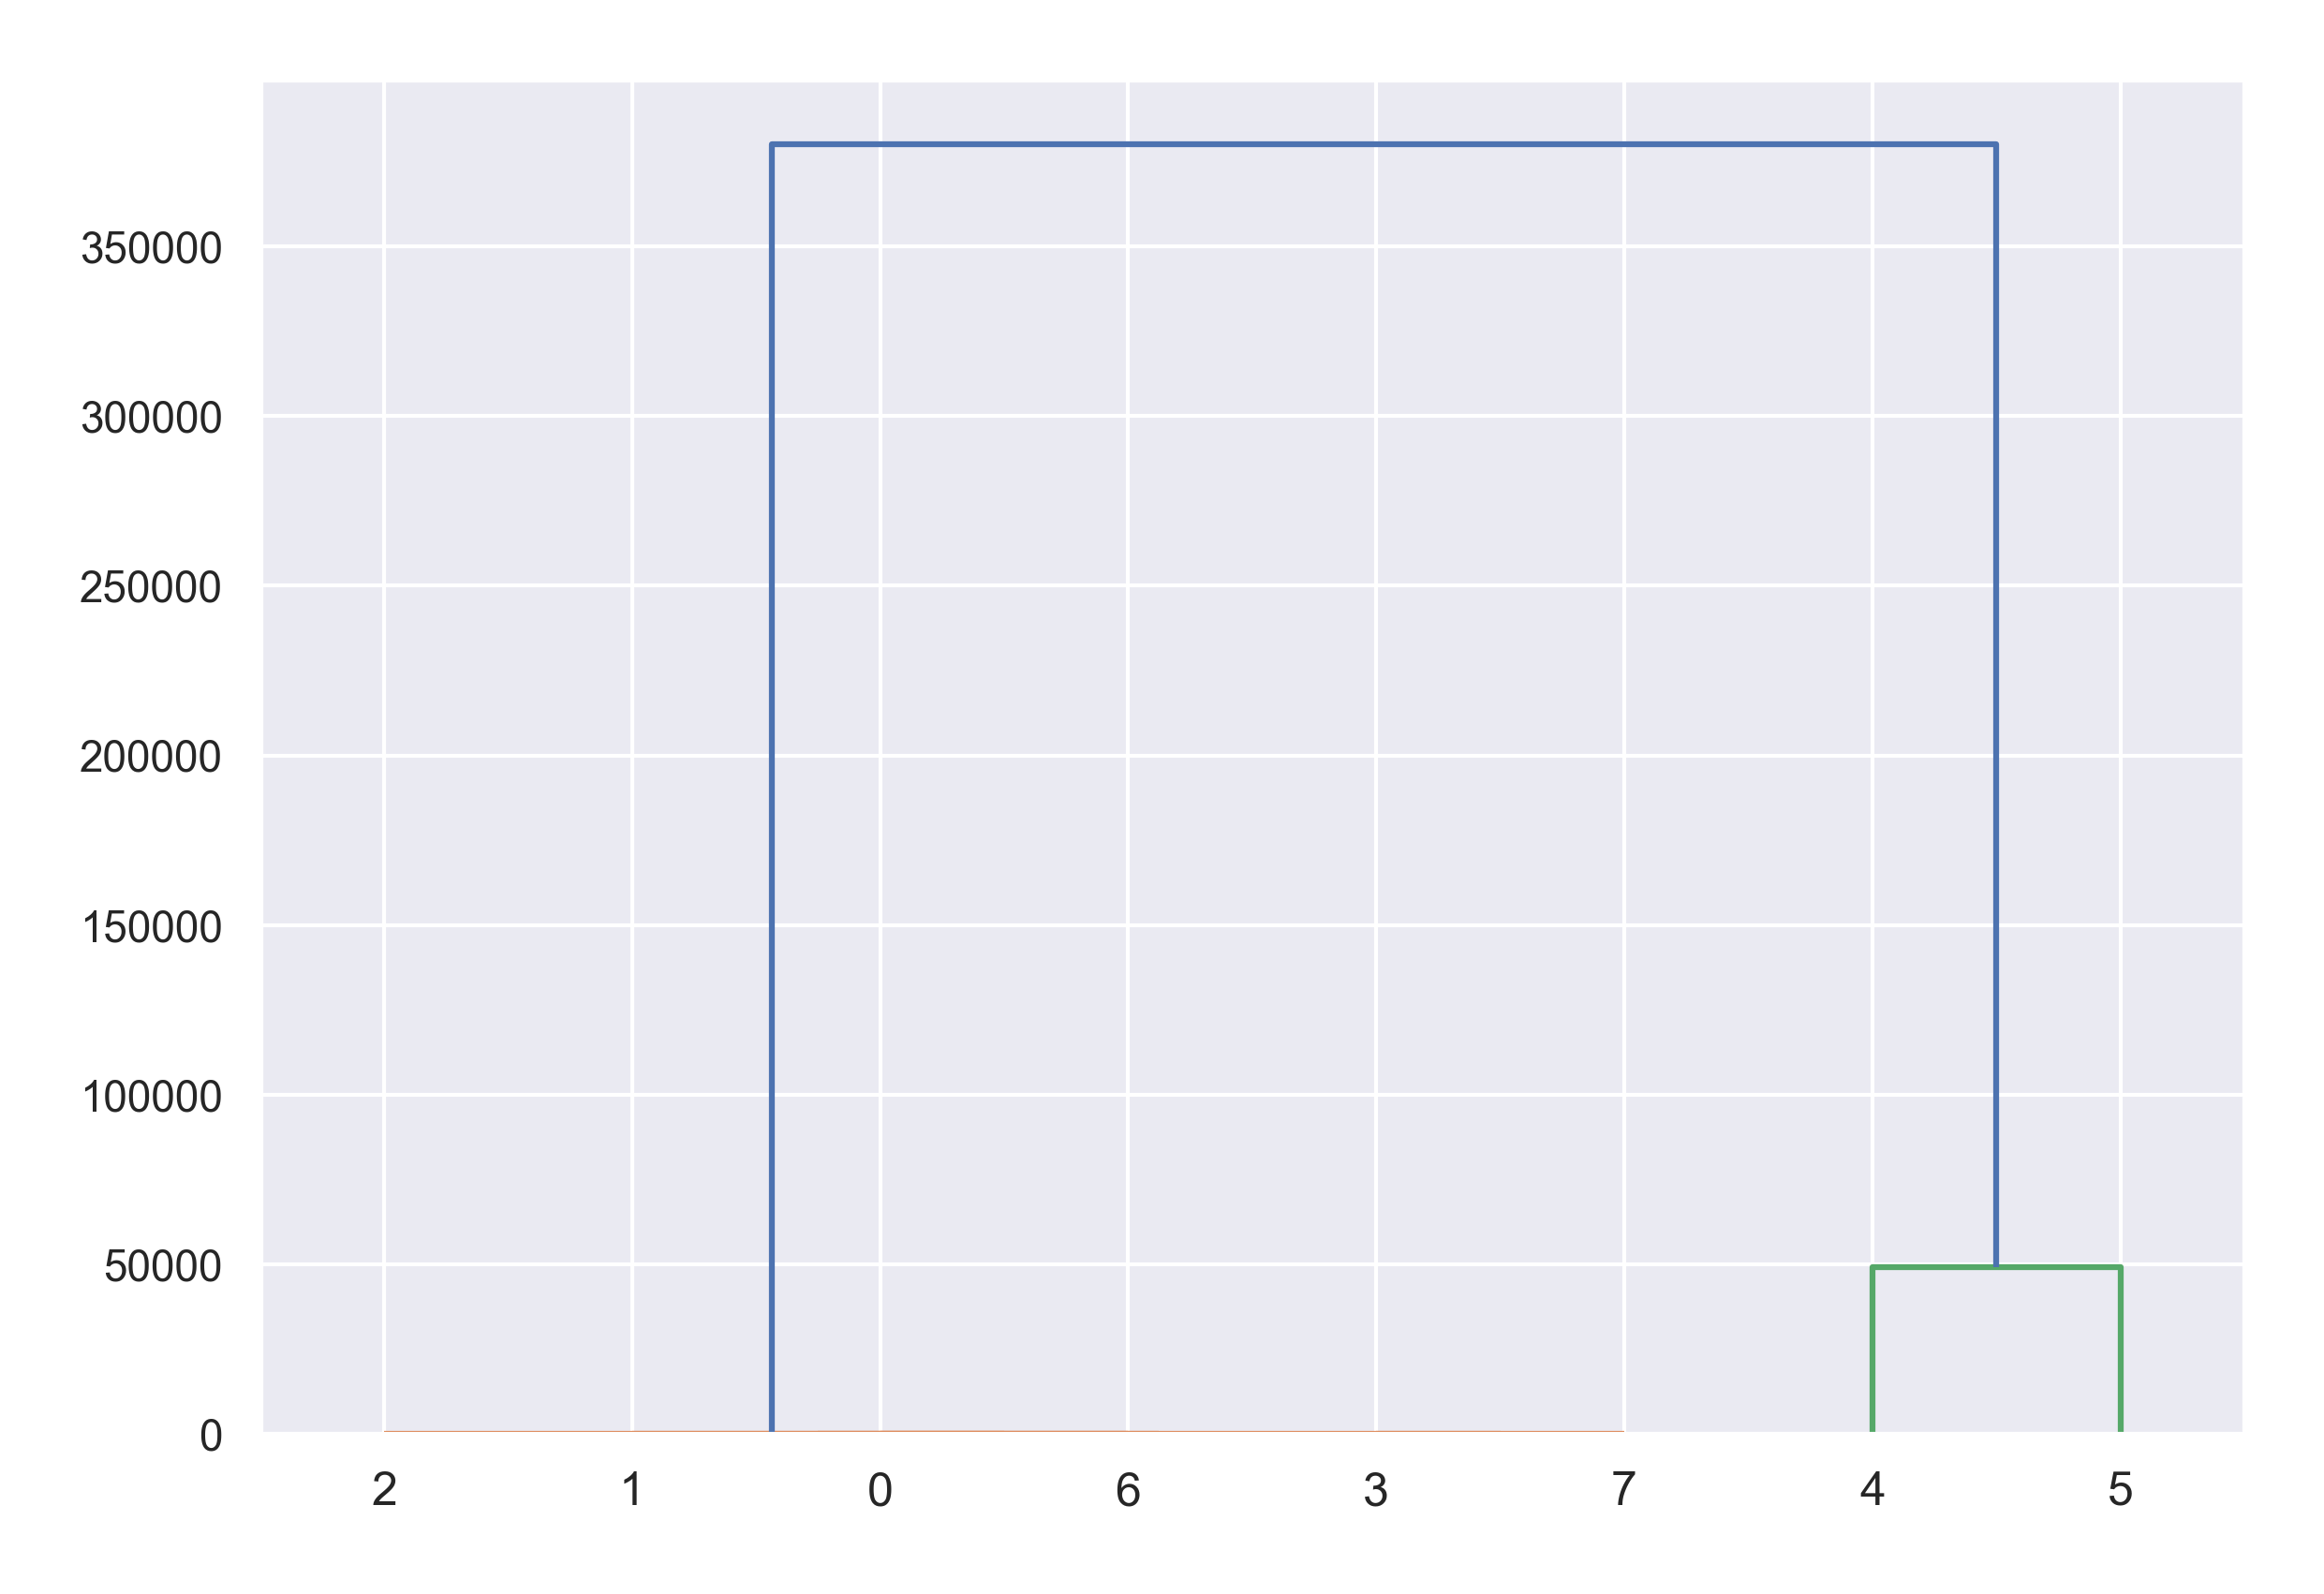

In [143]:
# Agglomerative Hierarchical Clustering
Z2 = linkage(yd2)
dendrogram(Z2)

In [99]:
species[species.name == 'tomato'].dna

636    AGGGCATCCTGTAACAATGGGAATGGTTGGATCTCCGCCCCAACAC...
Name: dna, dtype: object